In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# numpy (math) libary
import numpy as np 
import sys

In [2]:
### import PARAMETERS and CONSTANTS
from modules.ConstantsAndParameters import *

### import UTILITY functions
from modules.utils import *

#print_const()
#print_const(normalized=True)

### import model's EQUATIONS
from modules.model import *

In [3]:
history = 4
error = 1e-6
maxit = 5e2

ω_size = 1000
ω_range  = np.linspace(w2f(1.549e-6)/ω0, w2f(1.552e-6)/ω0, ω_size) # [Hz/ω0]
E_size = 12
E_range = np.power(np.logspace(0.8, 1.05, num=E_size, endpoint=True), 0.5) # [10^x mW/mW]
#E_range = np.power(np.logspace(1.03, 1.037, num=E_size, endpoint=True), 0.5) # [10^x mW/mW]
#E_range = np.power(np.append(np.logspace(-1, 1, num=E_size/2, endpoint=True),np.logspace(1.02, 1.05, num=E_size/2, endpoint=True)) , 0.5)
print(E_range**2)

[  6.30957344   6.64855511   7.00574855   7.3821322    7.77873705
   8.19664948   8.63701425   9.10103761   9.58999061  10.10521259
  10.64811486  11.22018454]


In [4]:
verbose = True
loops = True

### generate empty data storage
d = {}
d['Up']  = np.zeros((ω_size,E_size,history), dtype=complex)
d['Us']  = np.zeros((ω_size,E_size,history), dtype=complex)
d['Ut']  = np.zeros((ω_size,E_size,history), dtype=float)
d['ΔN']  = np.zeros((ω_size,E_size,history), dtype=float)
d['ΔT']  = np.zeros((ω_size,E_size,history), dtype=float)
d['Δω']  = np.zeros((ω_size,E_size,history), dtype=complex)

### two nested for loops, in input power and in
for E_i in range(E_size):
    for ω_i in range(ω_size):
        ### reset iteration index
        it = 0
        
        #params = (ωs, ωp, ω0, Ep, Es, τa, τb, τ0, 𝛾TH, 𝛾FC, MCp, n0, n2, dndT, dndN, dαdN, βtpa, Γ, V, Veff)
        #ñparams = (ω_range[ω_i], ωp, ω0, E_range[E_i], Es, τa, τb, τ0, 𝛾TH, 𝛾FC, MCp, n0, n2, dndT, dndN, dαdN, βtpa, Γ, V, Veff)
        ñparams = (1.0, ω_range[ω_i], ñω0, E_range[E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, 1, ñMCp, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, Γ, ñV, ñVeff)
        
        ### generate first set of data, with all initial condition set to zero ("cold resonance")
        if ω_i == 0:
            new_var = ñequations((0.0, 0.0, 0.0, 0.0, 0.0, 0.0), ñparams)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (d['Up'][ω_i-1,E_i,0], d['Us'][ω_i-1,E_i,0], d['Ut'][ω_i-1,E_i,0], d['ΔN'][ω_i-1,E_i,0], d['ΔT'][ω_i-1,E_i,0], d['Δω'][ω_i-1,E_i,0])
            new_var = ñequations(x0, ñparams)
            del x0
        
        ### store new values
        d['Up'][ω_i,E_i,0],d['Us'][ω_i,E_i,0],d['Ut'][ω_i,E_i,0],d['ΔN'][ω_i,E_i,0],d['ΔT'][ω_i,E_i,0],d['Δω'][ω_i,E_i,0] = new_var
        del new_var
        
        while (np.abs(d['Ut'][ω_i,E_i,0]-d['Ut'][ω_i,E_i,1]) >= error) & (it<=maxit):
            it += 1
            
            ### shift the history data
            d['Up'][ω_i,E_i,1:history]   = d['Up'][ω_i,E_i,0:history-1]
            d['Us'][ω_i,E_i,1:history]   = d['Us'][ω_i,E_i,0:history-1]
            d['Ut'][ω_i,E_i,1:history]   = d['Ut'][ω_i,E_i,0:history-1]
            d['ΔN'][ω_i,E_i,1:history]   = d['ΔN'][ω_i,E_i,0:history-1]
            d['ΔT'][ω_i,E_i,1:history]   = d['ΔT'][ω_i,E_i,0:history-1]
            d['Δω'][ω_i,E_i,1:history]   = d['Δω'][ω_i,E_i,0:history-1]
            
            ### put old data in vector, to become input of equations()
            old_var = (d['Up'][ω_i,E_i,1], d['Us'][ω_i,E_i,1], d['Ut'][ω_i,E_i,1], d['ΔN'][ω_i,E_i,1], d['ΔT'][ω_i,E_i,1], d['Δω'][ω_i,E_i,1])
            
            ### generate new values
            new_var = ñequations(old_var, ñparams)
            
            ### store new values
            d['Up'][ω_i,E_i,0],d['Us'][ω_i,E_i,0],d['Ut'][ω_i,E_i,0],d['ΔN'][ω_i,E_i,0],d['ΔT'][ω_i,E_i,0],d['Δω'][ω_i,E_i,0] = new_var
            
        if it>maxit:
            it = +1
            
            ### shift the history data
            d['Up'][ω_i,E_i,1:history]   = d['Up'][ω_i,E_i,0:history-1]
            d['Us'][ω_i,E_i,1:history]   = d['Us'][ω_i,E_i,0:history-1]
            d['Ut'][ω_i,E_i,1:history]   = d['Ut'][ω_i,E_i,0:history-1]
            d['ΔN'][ω_i,E_i,1:history]   = d['ΔN'][ω_i,E_i,0:history-1]
            d['ΔT'][ω_i,E_i,1:history]   = d['ΔT'][ω_i,E_i,0:history-1]
            d['Δω'][ω_i,E_i,1:history]   = d['Δω'][ω_i,E_i,0:history-1]
            
            x0 = (0.5*(d['Up'][ω_i,E_i,1]+d['Up'][ω_i,E_i,2]), 0.5*(d['Us'][ω_i,E_i,1]+d['Us'][ω_i,E_i,2]), 0.5*(d['Ut'][ω_i,E_i,1]+d['Ut'][ω_i,E_i,2]), 0.5*(d['ΔN'][ω_i,E_i,1]+d['ΔN'][ω_i,E_i,2]), 0.5*(d['ΔT'][ω_i,E_i,1]+d['ΔT'][ω_i,E_i,2]), 0.5*(d['Δω'][ω_i,E_i,1]+d['Δω'][ω_i,E_i,2]))
            
            ### generate new values
            new_var = ñequations(x0, ñparams)
            
            ### store new values
            d['Up'][ω_i,E_i,0],d['Us'][ω_i,E_i,0],d['Ut'][ω_i,E_i,0],d['ΔN'][ω_i,E_i,0],d['ΔT'][ω_i,E_i,0],d['Δω'][ω_i,E_i,0] = new_var
            
            while (np.abs(d['Ut'][ω_i,E_i,0]-d['Ut'][ω_i,E_i,1]) >= error) & (it<=2*maxit):
                it += 1
                
                ### shift the history data
                d['Up'][ω_i,E_i,1:history]   = d['Up'][ω_i,E_i,0:history-1]
                d['Us'][ω_i,E_i,1:history]   = d['Us'][ω_i,E_i,0:history-1]
                d['Ut'][ω_i,E_i,1:history]   = d['Ut'][ω_i,E_i,0:history-1]
                d['ΔN'][ω_i,E_i,1:history]   = d['ΔN'][ω_i,E_i,0:history-1]
                d['ΔT'][ω_i,E_i,1:history]   = d['ΔT'][ω_i,E_i,0:history-1]
                d['Δω'][ω_i,E_i,1:history]   = d['Δω'][ω_i,E_i,0:history-1]
                
                ### put old data in vector, to become input of equations()
                old_var = (0.5*(d['Up'][ω_i,E_i,1]+d['Up'][ω_i,E_i,2]), 0.5*(d['Us'][ω_i,E_i,1]+d['Us'][ω_i,E_i,2]),
                           0.5*(d['Ut'][ω_i,E_i,1]+d['Ut'][ω_i,E_i,2]), 0.5*(d['ΔN'][ω_i,E_i,1]+d['ΔN'][ω_i,E_i,2]),
                           0.5*(d['ΔT'][ω_i,E_i,1]+d['ΔT'][ω_i,E_i,2]), 0.5*(d['Δω'][ω_i,E_i,1]+d['Δω'][ω_i,E_i,2]))
                
                ### generate new values
                new_var = ñequations(old_var, ñparams)
                
                ### store new values
                d['Up'][ω_i,E_i,0],d['Us'][ω_i,E_i,0],d['Ut'][ω_i,E_i,0],d['ΔN'][ω_i,E_i,0],d['ΔT'][ω_i,E_i,0],d['Δω'][ω_i,E_i,0] = new_var
                    
        if verbose:
            print("%3.1f"%((1.0+ω_i)/ω_size*100), "%%\tP %.2e,"%(E_range[E_i]**2*P0), " λ %.5f"%f2w(ω_range[ω_i]*1e-6*ω0), end='')
            print(", iteration # %d,"%it , " error %.4e"%np.abs(d['Ut'][ω_i,E_i,0]-d['Ut'][ω_i,E_i,1]))
    if loops:
        print("%3.1f"%((1.0+E_i)/E_size*100), "%%\tP %.2f"%(E_range[E_i]**2),"mW ended")
    #elif verbose:
    print()

print("\nall loops have ended")

0.1 %	P 6.31e-03,  λ 1.54900, iteration # 7,  error 4.5188e-08
0.2 %	P 6.31e-03,  λ 1.54900, iteration # 5,  error 2.8576e-07
0.3 %	P 6.31e-03,  λ 1.54901, iteration # 5,  error 2.9983e-07
0.4 %	P 6.31e-03,  λ 1.54901, iteration # 5,  error 3.1464e-07
0.5 %	P 6.31e-03,  λ 1.54901, iteration # 5,  error 3.3021e-07
0.6 %	P 6.31e-03,  λ 1.54901, iteration # 5,  error 3.4658e-07
0.7 %	P 6.31e-03,  λ 1.54902, iteration # 5,  error 3.6381e-07
0.8 %	P 6.31e-03,  λ 1.54902, iteration # 5,  error 3.8194e-07
0.9 %	P 6.31e-03,  λ 1.54902, iteration # 5,  error 4.0101e-07
1.0 %	P 6.31e-03,  λ 1.54903, iteration # 5,  error 4.2108e-07
1.1 %	P 6.31e-03,  λ 1.54903, iteration # 5,  error 4.4221e-07
1.2 %	P 6.31e-03,  λ 1.54903, iteration # 5,  error 4.6444e-07
1.3 %	P 6.31e-03,  λ 1.54904, iteration # 5,  error 4.8784e-07
1.4 %	P 6.31e-03,  λ 1.54904, iteration # 5,  error 5.1249e-07
1.5 %	P 6.31e-03,  λ 1.54904, iteration # 5,  error 5.3843e-07
1.6 %	P 6.31e-03,  λ 1.54904, iteration # 5,  error 5.6

27.6 %	P 6.31e-03,  λ 1.54982, iteration # 27,  error 6.3986e-07
27.7 %	P 6.31e-03,  λ 1.54983, iteration # 27,  error 8.3533e-07
27.8 %	P 6.31e-03,  λ 1.54983, iteration # 28,  error 5.3818e-07
27.9 %	P 6.31e-03,  λ 1.54983, iteration # 28,  error 7.0699e-07
28.0 %	P 6.31e-03,  λ 1.54984, iteration # 28,  error 9.2723e-07
28.1 %	P 6.31e-03,  λ 1.54984, iteration # 29,  error 6.1714e-07
28.2 %	P 6.31e-03,  λ 1.54984, iteration # 29,  error 8.1411e-07
28.3 %	P 6.31e-03,  λ 1.54985, iteration # 30,  error 5.5506e-07
28.4 %	P 6.31e-03,  λ 1.54985, iteration # 30,  error 7.3625e-07
28.5 %	P 6.31e-03,  λ 1.54985, iteration # 30,  error 9.7469e-07
28.6 %	P 6.31e-03,  λ 1.54985, iteration # 31,  error 6.8519e-07
28.7 %	P 6.31e-03,  λ 1.54986, iteration # 31,  error 9.1161e-07
28.8 %	P 6.31e-03,  λ 1.54986, iteration # 32,  error 6.5553e-07
28.9 %	P 6.31e-03,  λ 1.54986, iteration # 32,  error 8.7620e-07
29.0 %	P 6.31e-03,  λ 1.54987, iteration # 33,  error 6.4406e-07
29.1 %	P 6.31e-03,  λ 1.5

41.2 %	P 6.31e-03,  λ 1.55023, iteration # 27,  error 5.3351e-07
41.3 %	P 6.31e-03,  λ 1.55024, iteration # 25,  error 9.6502e-07
41.4 %	P 6.31e-03,  λ 1.55024, iteration # 24,  error 8.4817e-07
41.5 %	P 6.31e-03,  λ 1.55024, iteration # 23,  error 7.5272e-07
41.6 %	P 6.31e-03,  λ 1.55024, iteration # 22,  error 6.7522e-07
41.7 %	P 6.31e-03,  λ 1.55025, iteration # 21,  error 6.1304e-07
41.8 %	P 6.31e-03,  λ 1.55025, iteration # 20,  error 5.6396e-07
41.9 %	P 6.31e-03,  λ 1.55025, iteration # 19,  error 5.2638e-07
42.0 %	P 6.31e-03,  λ 1.55026, iteration # 18,  error 4.9898e-07
42.1 %	P 6.31e-03,  λ 1.55026, iteration # 17,  error 4.8101e-07
42.2 %	P 6.31e-03,  λ 1.55026, iteration # 16,  error 4.7196e-07
42.3 %	P 6.31e-03,  λ 1.55027, iteration # 15,  error 4.7163e-07
42.4 %	P 6.31e-03,  λ 1.55027, iteration # 14,  error 4.8013e-07
42.5 %	P 6.31e-03,  λ 1.55027, iteration # 13,  error 4.9752e-07
42.6 %	P 6.31e-03,  λ 1.55027, iteration # 12,  error 5.2361e-07
42.7 %	P 6.31e-03,  λ 1.5

61.1 %	P 6.31e-03,  λ 1.55083, iteration # 6,  error 6.9894e-07
61.2 %	P 6.31e-03,  λ 1.55083, iteration # 6,  error 6.4931e-07
61.3 %	P 6.31e-03,  λ 1.55084, iteration # 6,  error 6.0337e-07
61.4 %	P 6.31e-03,  λ 1.55084, iteration # 6,  error 5.6082e-07
61.5 %	P 6.31e-03,  λ 1.55084, iteration # 6,  error 5.2142e-07
61.6 %	P 6.31e-03,  λ 1.55085, iteration # 6,  error 4.8491e-07
61.7 %	P 6.31e-03,  λ 1.55085, iteration # 6,  error 4.5108e-07
61.8 %	P 6.31e-03,  λ 1.55085, iteration # 6,  error 4.1971e-07
61.9 %	P 6.31e-03,  λ 1.55085, iteration # 6,  error 3.9063e-07
62.0 %	P 6.31e-03,  λ 1.55086, iteration # 6,  error 3.6365e-07
62.1 %	P 6.31e-03,  λ 1.55086, iteration # 6,  error 3.3863e-07
62.2 %	P 6.31e-03,  λ 1.55086, iteration # 6,  error 3.1540e-07
62.3 %	P 6.31e-03,  λ 1.55087, iteration # 6,  error 2.9384e-07
62.4 %	P 6.31e-03,  λ 1.55087, iteration # 6,  error 2.7382e-07
62.5 %	P 6.31e-03,  λ 1.55087, iteration # 6,  error 2.5523e-07
62.6 %	P 6.31e-03,  λ 1.55088, iteration

87.9 %	P 6.31e-03,  λ 1.55164, iteration # 4,  error 1.1039e-08
88.0 %	P 6.31e-03,  λ 1.55164, iteration # 4,  error 1.0744e-08
88.1 %	P 6.31e-03,  λ 1.55164, iteration # 4,  error 1.0458e-08
88.2 %	P 6.31e-03,  λ 1.55165, iteration # 4,  error 1.0180e-08
88.3 %	P 6.31e-03,  λ 1.55165, iteration # 4,  error 9.9097e-09
88.4 %	P 6.31e-03,  λ 1.55165, iteration # 4,  error 9.6475e-09
88.5 %	P 6.31e-03,  λ 1.55165, iteration # 4,  error 9.3922e-09
88.6 %	P 6.31e-03,  λ 1.55166, iteration # 4,  error 9.1443e-09
88.7 %	P 6.31e-03,  λ 1.55166, iteration # 4,  error 8.9033e-09
88.8 %	P 6.31e-03,  λ 1.55166, iteration # 4,  error 8.6693e-09
88.9 %	P 6.31e-03,  λ 1.55167, iteration # 4,  error 8.4416e-09
89.0 %	P 6.31e-03,  λ 1.55167, iteration # 4,  error 8.2198e-09
89.1 %	P 6.31e-03,  λ 1.55167, iteration # 4,  error 8.0046e-09
89.2 %	P 6.31e-03,  λ 1.55168, iteration # 4,  error 7.7958e-09
89.3 %	P 6.31e-03,  λ 1.55168, iteration # 4,  error 7.5918e-09
89.4 %	P 6.31e-03,  λ 1.55168, iteration

2.9 %	P 6.65e-03,  λ 1.54908, iteration # 6,  error 5.7423e-08
3.0 %	P 6.65e-03,  λ 1.54909, iteration # 6,  error 6.0939e-08
3.1 %	P 6.65e-03,  λ 1.54909, iteration # 6,  error 6.4679e-08
3.2 %	P 6.65e-03,  λ 1.54909, iteration # 6,  error 6.8658e-08
3.3 %	P 6.65e-03,  λ 1.54910, iteration # 6,  error 7.2894e-08
3.4 %	P 6.65e-03,  λ 1.54910, iteration # 6,  error 7.7401e-08
3.5 %	P 6.65e-03,  λ 1.54910, iteration # 6,  error 8.2195e-08
3.6 %	P 6.65e-03,  λ 1.54910, iteration # 6,  error 8.7298e-08
3.7 %	P 6.65e-03,  λ 1.54911, iteration # 6,  error 9.2732e-08
3.8 %	P 6.65e-03,  λ 1.54911, iteration # 6,  error 9.8520e-08
3.9 %	P 6.65e-03,  λ 1.54911, iteration # 6,  error 1.0468e-07
4.0 %	P 6.65e-03,  λ 1.54912, iteration # 6,  error 1.1124e-07
4.1 %	P 6.65e-03,  λ 1.54912, iteration # 6,  error 1.1823e-07
4.2 %	P 6.65e-03,  λ 1.54912, iteration # 6,  error 1.2567e-07
4.3 %	P 6.65e-03,  λ 1.54913, iteration # 6,  error 1.3360e-07
4.4 %	P 6.65e-03,  λ 1.54913, iteration # 6,  error 1.4

20.1 %	P 6.65e-03,  λ 1.54960, iteration # 13,  error 3.2171e-07
20.2 %	P 6.65e-03,  λ 1.54960, iteration # 13,  error 3.7695e-07
20.3 %	P 6.65e-03,  λ 1.54961, iteration # 13,  error 4.4167e-07
20.4 %	P 6.65e-03,  λ 1.54961, iteration # 13,  error 5.1749e-07
20.5 %	P 6.65e-03,  λ 1.54961, iteration # 13,  error 6.0631e-07
20.6 %	P 6.65e-03,  λ 1.54961, iteration # 13,  error 7.1034e-07
20.7 %	P 6.65e-03,  λ 1.54962, iteration # 13,  error 8.3217e-07
20.8 %	P 6.65e-03,  λ 1.54962, iteration # 13,  error 9.7486e-07
20.9 %	P 6.65e-03,  λ 1.54962, iteration # 14,  error 2.7999e-07
21.0 %	P 6.65e-03,  λ 1.54963, iteration # 14,  error 3.3168e-07
21.1 %	P 6.65e-03,  λ 1.54963, iteration # 14,  error 3.9289e-07
21.2 %	P 6.65e-03,  λ 1.54963, iteration # 14,  error 4.6533e-07
21.3 %	P 6.65e-03,  λ 1.54964, iteration # 14,  error 5.5110e-07
21.4 %	P 6.65e-03,  λ 1.54964, iteration # 14,  error 6.5259e-07
21.5 %	P 6.65e-03,  λ 1.54964, iteration # 14,  error 7.7269e-07
21.6 %	P 6.65e-03,  λ 1.5

32.7 %	P 6.65e-03,  λ 1.54998, iteration # 67,  error 8.0882e-07
32.8 %	P 6.65e-03,  λ 1.54998, iteration # 68,  error 8.8612e-07
32.9 %	P 6.65e-03,  λ 1.54998, iteration # 69,  error 9.7451e-07
33.0 %	P 6.65e-03,  λ 1.54999, iteration # 71,  error 8.1431e-07
33.1 %	P 6.65e-03,  λ 1.54999, iteration # 72,  error 9.0606e-07
33.2 %	P 6.65e-03,  λ 1.54999, iteration # 74,  error 7.7329e-07
33.3 %	P 6.65e-03,  λ 1.55000, iteration # 75,  error 8.6868e-07
33.4 %	P 6.65e-03,  λ 1.55000, iteration # 76,  error 9.7715e-07
33.5 %	P 6.65e-03,  λ 1.55000, iteration # 78,  error 8.5452e-07
33.6 %	P 6.65e-03,  λ 1.55000, iteration # 79,  error 9.6723e-07
33.7 %	P 6.65e-03,  λ 1.55001, iteration # 81,  error 8.5810e-07
33.8 %	P 6.65e-03,  λ 1.55001, iteration # 82,  error 9.7500e-07
33.9 %	P 6.65e-03,  λ 1.55001, iteration # 84,  error 8.7502e-07
34.0 %	P 6.65e-03,  λ 1.55002, iteration # 85,  error 9.9547e-07
34.1 %	P 6.65e-03,  λ 1.55002, iteration # 87,  error 9.0094e-07
34.2 %	P 6.65e-03,  λ 1.5

50.9 %	P 6.65e-03,  λ 1.55052, iteration # 13,  error 7.0575e-07
51.0 %	P 6.65e-03,  λ 1.55053, iteration # 13,  error 5.4656e-07
51.1 %	P 6.65e-03,  λ 1.55053, iteration # 13,  error 4.2422e-07
51.2 %	P 6.65e-03,  λ 1.55053, iteration # 13,  error 3.2996e-07
51.3 %	P 6.65e-03,  λ 1.55054, iteration # 13,  error 2.5718e-07
51.4 %	P 6.65e-03,  λ 1.55054, iteration # 12,  error 9.2864e-07
51.5 %	P 6.65e-03,  λ 1.55054, iteration # 12,  error 7.3956e-07
51.6 %	P 6.65e-03,  λ 1.55055, iteration # 12,  error 5.9005e-07
51.7 %	P 6.65e-03,  λ 1.55055, iteration # 12,  error 4.7160e-07
51.8 %	P 6.65e-03,  λ 1.55055, iteration # 12,  error 3.7758e-07
51.9 %	P 6.65e-03,  λ 1.55055, iteration # 12,  error 3.0281e-07
52.0 %	P 6.65e-03,  λ 1.55056, iteration # 12,  error 2.4325e-07
52.1 %	P 6.65e-03,  λ 1.55056, iteration # 12,  error 1.9573e-07
52.2 %	P 6.65e-03,  λ 1.55056, iteration # 11,  error 8.3569e-07
52.3 %	P 6.65e-03,  λ 1.55057, iteration # 11,  error 6.8573e-07
52.4 %	P 6.65e-03,  λ 1.5

78.7 %	P 6.65e-03,  λ 1.55136, iteration # 4,  error 2.1931e-07
78.8 %	P 6.65e-03,  λ 1.55136, iteration # 4,  error 2.1231e-07
78.9 %	P 6.65e-03,  λ 1.55137, iteration # 4,  error 2.0555e-07
79.0 %	P 6.65e-03,  λ 1.55137, iteration # 4,  error 1.9902e-07
79.1 %	P 6.65e-03,  λ 1.55137, iteration # 4,  error 1.9271e-07
79.2 %	P 6.65e-03,  λ 1.55137, iteration # 4,  error 1.8661e-07
79.3 %	P 6.65e-03,  λ 1.55138, iteration # 4,  error 1.8072e-07
79.4 %	P 6.65e-03,  λ 1.55138, iteration # 4,  error 1.7503e-07
79.5 %	P 6.65e-03,  λ 1.55138, iteration # 4,  error 1.6953e-07
79.6 %	P 6.65e-03,  λ 1.55139, iteration # 4,  error 1.6421e-07
79.7 %	P 6.65e-03,  λ 1.55139, iteration # 4,  error 1.5907e-07
79.8 %	P 6.65e-03,  λ 1.55139, iteration # 4,  error 1.5410e-07
79.9 %	P 6.65e-03,  λ 1.55140, iteration # 4,  error 1.4929e-07
80.0 %	P 6.65e-03,  λ 1.55140, iteration # 4,  error 1.4465e-07
80.1 %	P 6.65e-03,  λ 1.55140, iteration # 4,  error 1.4016e-07
80.2 %	P 6.65e-03,  λ 1.55140, iteration

93.8 %	P 6.65e-03,  λ 1.55181, iteration # 3,  error 5.2476e-07
93.9 %	P 6.65e-03,  λ 1.55182, iteration # 3,  error 5.1459e-07
94.0 %	P 6.65e-03,  λ 1.55182, iteration # 3,  error 5.0463e-07
94.1 %	P 6.65e-03,  λ 1.55182, iteration # 3,  error 4.9487e-07
94.2 %	P 6.65e-03,  λ 1.55183, iteration # 3,  error 4.8532e-07
94.3 %	P 6.65e-03,  λ 1.55183, iteration # 3,  error 4.7597e-07
94.4 %	P 6.65e-03,  λ 1.55183, iteration # 3,  error 4.6682e-07
94.5 %	P 6.65e-03,  λ 1.55183, iteration # 3,  error 4.5785e-07
94.6 %	P 6.65e-03,  λ 1.55184, iteration # 3,  error 4.4907e-07
94.7 %	P 6.65e-03,  λ 1.55184, iteration # 3,  error 4.4048e-07
94.8 %	P 6.65e-03,  λ 1.55184, iteration # 3,  error 4.3206e-07
94.9 %	P 6.65e-03,  λ 1.55185, iteration # 3,  error 4.2381e-07
95.0 %	P 6.65e-03,  λ 1.55185, iteration # 3,  error 4.1574e-07
95.1 %	P 6.65e-03,  λ 1.55185, iteration # 3,  error 4.0783e-07
95.2 %	P 6.65e-03,  λ 1.55186, iteration # 3,  error 4.0008e-07
95.3 %	P 6.65e-03,  λ 1.55186, iteration

11.7 %	P 7.01e-03,  λ 1.54935, iteration # 8,  error 2.2222e-07
11.8 %	P 7.01e-03,  λ 1.54935, iteration # 8,  error 2.4362e-07
11.9 %	P 7.01e-03,  λ 1.54935, iteration # 8,  error 2.6712e-07
12.0 %	P 7.01e-03,  λ 1.54936, iteration # 8,  error 2.9295e-07
12.1 %	P 7.01e-03,  λ 1.54936, iteration # 8,  error 3.2132e-07
12.2 %	P 7.01e-03,  λ 1.54936, iteration # 8,  error 3.5252e-07
12.3 %	P 7.01e-03,  λ 1.54937, iteration # 8,  error 3.8679e-07
12.4 %	P 7.01e-03,  λ 1.54937, iteration # 8,  error 4.2448e-07
12.5 %	P 7.01e-03,  λ 1.54937, iteration # 8,  error 4.6592e-07
12.6 %	P 7.01e-03,  λ 1.54937, iteration # 8,  error 5.1149e-07
12.7 %	P 7.01e-03,  λ 1.54938, iteration # 8,  error 5.6161e-07
12.8 %	P 7.01e-03,  λ 1.54938, iteration # 8,  error 6.1674e-07
12.9 %	P 7.01e-03,  λ 1.54938, iteration # 8,  error 6.7739e-07
13.0 %	P 7.01e-03,  λ 1.54939, iteration # 8,  error 7.4415e-07
13.1 %	P 7.01e-03,  λ 1.54939, iteration # 8,  error 8.1761e-07
13.2 %	P 7.01e-03,  λ 1.54939, iteration

24.8 %	P 7.01e-03,  λ 1.54974, iteration # 21,  error 4.1190e-07
24.9 %	P 7.01e-03,  λ 1.54974, iteration # 21,  error 5.1922e-07
25.0 %	P 7.01e-03,  λ 1.54975, iteration # 21,  error 6.5406e-07
25.1 %	P 7.01e-03,  λ 1.54975, iteration # 21,  error 8.2335e-07
25.2 %	P 7.01e-03,  λ 1.54975, iteration # 22,  error 4.2151e-07
25.3 %	P 7.01e-03,  λ 1.54976, iteration # 22,  error 5.3542e-07
25.4 %	P 7.01e-03,  λ 1.54976, iteration # 22,  error 6.7959e-07
25.5 %	P 7.01e-03,  λ 1.54976, iteration # 22,  error 8.6194e-07
25.6 %	P 7.01e-03,  λ 1.54976, iteration # 23,  error 4.6332e-07
25.7 %	P 7.01e-03,  λ 1.54977, iteration # 23,  error 5.9277e-07
25.8 %	P 7.01e-03,  λ 1.54977, iteration # 23,  error 7.5773e-07
25.9 %	P 7.01e-03,  λ 1.54977, iteration # 23,  error 9.6774e-07
26.0 %	P 7.01e-03,  λ 1.54978, iteration # 24,  error 5.4563e-07
26.1 %	P 7.01e-03,  λ 1.54978, iteration # 24,  error 7.0268e-07
26.2 %	P 7.01e-03,  λ 1.54978, iteration # 24,  error 9.0406e-07
26.3 %	P 7.01e-03,  λ 1.5

37.4 %	P 7.01e-03,  λ 1.55012, iteration # 164,  error 9.9991e-07
37.5 %	P 7.01e-03,  λ 1.55012, iteration # 163,  error 9.8611e-07
37.6 %	P 7.01e-03,  λ 1.55012, iteration # 162,  error 9.4031e-07
37.7 %	P 7.01e-03,  λ 1.55013, iteration # 160,  error 9.8027e-07
37.8 %	P 7.01e-03,  λ 1.55013, iteration # 158,  error 9.9052e-07
37.9 %	P 7.01e-03,  λ 1.55013, iteration # 156,  error 9.7063e-07
38.0 %	P 7.01e-03,  λ 1.55014, iteration # 154,  error 9.2254e-07
38.1 %	P 7.01e-03,  λ 1.55014, iteration # 151,  error 9.6970e-07
38.2 %	P 7.01e-03,  λ 1.55014, iteration # 148,  error 9.9444e-07
38.3 %	P 7.01e-03,  λ 1.55015, iteration # 145,  error 9.9633e-07
38.4 %	P 7.01e-03,  λ 1.55015, iteration # 142,  error 9.7624e-07
38.5 %	P 7.01e-03,  λ 1.55015, iteration # 139,  error 9.3692e-07
38.6 %	P 7.01e-03,  λ 1.55015, iteration # 136,  error 8.8177e-07
38.7 %	P 7.01e-03,  λ 1.55016, iteration # 132,  error 9.4627e-07
38.8 %	P 7.01e-03,  λ 1.55016, iteration # 129,  error 8.6362e-07
38.9 %	P 7

61.4 %	P 7.01e-03,  λ 1.55084, iteration # 7,  error 7.5703e-08
61.5 %	P 7.01e-03,  λ 1.55084, iteration # 7,  error 6.9600e-08
61.6 %	P 7.01e-03,  λ 1.55085, iteration # 7,  error 6.4007e-08
61.7 %	P 7.01e-03,  λ 1.55085, iteration # 6,  error 9.9960e-07
61.8 %	P 7.01e-03,  λ 1.55085, iteration # 6,  error 9.2947e-07
61.9 %	P 7.01e-03,  λ 1.55085, iteration # 6,  error 8.6448e-07
62.0 %	P 7.01e-03,  λ 1.55086, iteration # 6,  error 8.0426e-07
62.1 %	P 7.01e-03,  λ 1.55086, iteration # 6,  error 7.4843e-07
62.2 %	P 7.01e-03,  λ 1.55086, iteration # 6,  error 6.9665e-07
62.3 %	P 7.01e-03,  λ 1.55087, iteration # 6,  error 6.4862e-07
62.4 %	P 7.01e-03,  λ 1.55087, iteration # 6,  error 6.0406e-07
62.5 %	P 7.01e-03,  λ 1.55087, iteration # 6,  error 5.6270e-07
62.6 %	P 7.01e-03,  λ 1.55088, iteration # 6,  error 5.2431e-07
62.7 %	P 7.01e-03,  λ 1.55088, iteration # 6,  error 4.8866e-07
62.8 %	P 7.01e-03,  λ 1.55088, iteration # 6,  error 4.5554e-07
62.9 %	P 7.01e-03,  λ 1.55088, iteration

89.3 %	P 7.01e-03,  λ 1.55168, iteration # 4,  error 1.2889e-08
89.4 %	P 7.01e-03,  λ 1.55168, iteration # 4,  error 1.2553e-08
89.5 %	P 7.01e-03,  λ 1.55168, iteration # 4,  error 1.2226e-08
89.6 %	P 7.01e-03,  λ 1.55169, iteration # 4,  error 1.1908e-08
89.7 %	P 7.01e-03,  λ 1.55169, iteration # 4,  error 1.1599e-08
89.8 %	P 7.01e-03,  λ 1.55169, iteration # 4,  error 1.1299e-08
89.9 %	P 7.01e-03,  λ 1.55170, iteration # 4,  error 1.1007e-08
90.0 %	P 7.01e-03,  λ 1.55170, iteration # 4,  error 1.0723e-08
90.1 %	P 7.01e-03,  λ 1.55170, iteration # 4,  error 1.0446e-08
90.2 %	P 7.01e-03,  λ 1.55171, iteration # 4,  error 1.0178e-08
90.3 %	P 7.01e-03,  λ 1.55171, iteration # 4,  error 9.9172e-09
90.4 %	P 7.01e-03,  λ 1.55171, iteration # 4,  error 9.6630e-09
90.5 %	P 7.01e-03,  λ 1.55171, iteration # 4,  error 9.4152e-09
90.6 %	P 7.01e-03,  λ 1.55172, iteration # 4,  error 9.1752e-09
90.7 %	P 7.01e-03,  λ 1.55172, iteration # 4,  error 8.9412e-09
90.8 %	P 7.01e-03,  λ 1.55172, iteration

9.6 %	P 7.38e-03,  λ 1.54928, iteration # 7,  error 6.4375e-07
9.7 %	P 7.38e-03,  λ 1.54929, iteration # 7,  error 6.9598e-07
9.8 %	P 7.38e-03,  λ 1.54929, iteration # 7,  error 7.5255e-07
9.9 %	P 7.38e-03,  λ 1.54929, iteration # 7,  error 8.1386e-07
10.0 %	P 7.38e-03,  λ 1.54930, iteration # 7,  error 8.8030e-07
10.1 %	P 7.38e-03,  λ 1.54930, iteration # 7,  error 9.5232e-07
10.2 %	P 7.38e-03,  λ 1.54930, iteration # 8,  error 8.6912e-08
10.3 %	P 7.38e-03,  λ 1.54931, iteration # 8,  error 9.4987e-08
10.4 %	P 7.38e-03,  λ 1.54931, iteration # 8,  error 1.0383e-07
10.5 %	P 7.38e-03,  λ 1.54931, iteration # 8,  error 1.1351e-07
10.6 %	P 7.38e-03,  λ 1.54931, iteration # 8,  error 1.2412e-07
10.7 %	P 7.38e-03,  λ 1.54932, iteration # 8,  error 1.3574e-07
10.8 %	P 7.38e-03,  λ 1.54932, iteration # 8,  error 1.4848e-07
10.9 %	P 7.38e-03,  λ 1.54932, iteration # 8,  error 1.6244e-07
11.0 %	P 7.38e-03,  λ 1.54933, iteration # 8,  error 1.7775e-07
11.1 %	P 7.38e-03,  λ 1.54933, iteration # 8

23.6 %	P 7.38e-03,  λ 1.54970, iteration # 19,  error 4.1481e-07
23.7 %	P 7.38e-03,  λ 1.54971, iteration # 19,  error 5.1397e-07
23.8 %	P 7.38e-03,  λ 1.54971, iteration # 19,  error 6.3657e-07
23.9 %	P 7.38e-03,  λ 1.54971, iteration # 19,  error 7.8806e-07
24.0 %	P 7.38e-03,  λ 1.54972, iteration # 19,  error 9.7515e-07
24.1 %	P 7.38e-03,  λ 1.54972, iteration # 20,  error 4.5207e-07
24.2 %	P 7.38e-03,  λ 1.54972, iteration # 20,  error 5.6485e-07
24.3 %	P 7.38e-03,  λ 1.54973, iteration # 20,  error 7.0537e-07
24.4 %	P 7.38e-03,  λ 1.54973, iteration # 20,  error 8.8042e-07
24.5 %	P 7.38e-03,  λ 1.54973, iteration # 21,  error 4.2943e-07
24.6 %	P 7.38e-03,  λ 1.54973, iteration # 21,  error 5.4106e-07
24.7 %	P 7.38e-03,  λ 1.54974, iteration # 21,  error 6.8130e-07
24.8 %	P 7.38e-03,  λ 1.54974, iteration # 21,  error 8.5739e-07
24.9 %	P 7.38e-03,  λ 1.54974, iteration # 22,  error 4.3963e-07
25.0 %	P 7.38e-03,  λ 1.54975, iteration # 22,  error 5.5832e-07
25.1 %	P 7.38e-03,  λ 1.5

37.1 %	P 7.38e-03,  λ 1.55011, iteration # 291,  error 9.7974e-07
37.2 %	P 7.38e-03,  λ 1.55011, iteration # 294,  error 9.5752e-07
37.3 %	P 7.38e-03,  λ 1.55012, iteration # 296,  error 9.5341e-07
37.4 %	P 7.38e-03,  λ 1.55012, iteration # 297,  error 9.6393e-07
37.5 %	P 7.38e-03,  λ 1.55012, iteration # 297,  error 9.8719e-07
37.6 %	P 7.38e-03,  λ 1.55012, iteration # 297,  error 9.5644e-07
37.7 %	P 7.38e-03,  λ 1.55013, iteration # 296,  error 9.3643e-07
37.8 %	P 7.38e-03,  λ 1.55013, iteration # 293,  error 9.9129e-07
37.9 %	P 7.38e-03,  λ 1.55013, iteration # 290,  error 9.9323e-07
38.0 %	P 7.38e-03,  λ 1.55014, iteration # 287,  error 9.4245e-07
38.1 %	P 7.38e-03,  λ 1.55014, iteration # 282,  error 9.7478e-07
38.2 %	P 7.38e-03,  λ 1.55014, iteration # 277,  error 9.6041e-07
38.3 %	P 7.38e-03,  λ 1.55015, iteration # 271,  error 9.7157e-07
38.4 %	P 7.38e-03,  λ 1.55015, iteration # 265,  error 9.4288e-07
38.5 %	P 7.38e-03,  λ 1.55015, iteration # 258,  error 9.5027e-07
38.6 %	P 7

49.7 %	P 7.38e-03,  λ 1.55049, iteration # 19,  error 4.0209e-07
49.8 %	P 7.38e-03,  λ 1.55049, iteration # 18,  error 7.4159e-07
49.9 %	P 7.38e-03,  λ 1.55049, iteration # 18,  error 4.8746e-07
50.0 %	P 7.38e-03,  λ 1.55050, iteration # 17,  error 9.7163e-07
50.1 %	P 7.38e-03,  λ 1.55050, iteration # 17,  error 6.5976e-07
50.2 %	P 7.38e-03,  λ 1.55050, iteration # 17,  error 4.5020e-07
50.3 %	P 7.38e-03,  λ 1.55051, iteration # 16,  error 9.9182e-07
50.4 %	P 7.38e-03,  λ 1.55051, iteration # 16,  error 6.9736e-07
50.5 %	P 7.38e-03,  λ 1.55051, iteration # 16,  error 4.9234e-07
50.6 %	P 7.38e-03,  λ 1.55052, iteration # 16,  error 3.4899e-07
50.7 %	P 7.38e-03,  λ 1.55052, iteration # 15,  error 8.6559e-07
50.8 %	P 7.38e-03,  λ 1.55052, iteration # 15,  error 6.3055e-07
50.9 %	P 7.38e-03,  λ 1.55052, iteration # 15,  error 4.6089e-07
51.0 %	P 7.38e-03,  λ 1.55053, iteration # 15,  error 3.3799e-07
51.1 %	P 7.38e-03,  λ 1.55053, iteration # 14,  error 9.3687e-07
51.2 %	P 7.38e-03,  λ 1.5

75.3 %	P 7.38e-03,  λ 1.55126, iteration # 5,  error 2.3204e-08
75.4 %	P 7.38e-03,  λ 1.55126, iteration # 5,  error 2.2247e-08
75.5 %	P 7.38e-03,  λ 1.55126, iteration # 5,  error 2.1333e-08
75.6 %	P 7.38e-03,  λ 1.55127, iteration # 5,  error 2.0456e-08
75.7 %	P 7.38e-03,  λ 1.55127, iteration # 5,  error 1.9618e-08
75.8 %	P 7.38e-03,  λ 1.55127, iteration # 4,  error 9.9249e-07
75.9 %	P 7.38e-03,  λ 1.55128, iteration # 4,  error 9.5865e-07
76.0 %	P 7.38e-03,  λ 1.55128, iteration # 4,  error 9.2603e-07
76.1 %	P 7.38e-03,  λ 1.55128, iteration # 4,  error 8.9460e-07
76.2 %	P 7.38e-03,  λ 1.55128, iteration # 4,  error 8.6431e-07
76.3 %	P 7.38e-03,  λ 1.55129, iteration # 4,  error 8.3510e-07
76.4 %	P 7.38e-03,  λ 1.55129, iteration # 4,  error 8.0695e-07
76.5 %	P 7.38e-03,  λ 1.55129, iteration # 4,  error 7.7980e-07
76.6 %	P 7.38e-03,  λ 1.55130, iteration # 4,  error 7.5363e-07
76.7 %	P 7.38e-03,  λ 1.55130, iteration # 4,  error 7.2840e-07
76.8 %	P 7.38e-03,  λ 1.55130, iteration

91.9 %	P 7.38e-03,  λ 1.55176, iteration # 4,  error 8.5727e-09
92.0 %	P 7.38e-03,  λ 1.55176, iteration # 4,  error 8.3586e-09
92.1 %	P 7.38e-03,  λ 1.55176, iteration # 4,  error 8.1503e-09
92.2 %	P 7.38e-03,  λ 1.55177, iteration # 4,  error 7.9481e-09
92.3 %	P 7.38e-03,  λ 1.55177, iteration # 4,  error 7.7503e-09
92.4 %	P 7.38e-03,  λ 1.55177, iteration # 4,  error 7.5579e-09
92.5 %	P 7.38e-03,  λ 1.55177, iteration # 4,  error 7.3709e-09
92.6 %	P 7.38e-03,  λ 1.55178, iteration # 4,  error 7.1886e-09
92.7 %	P 7.38e-03,  λ 1.55178, iteration # 3,  error 9.9557e-07
92.8 %	P 7.38e-03,  λ 1.55178, iteration # 3,  error 9.7590e-07
92.9 %	P 7.38e-03,  λ 1.55179, iteration # 3,  error 9.5664e-07
93.0 %	P 7.38e-03,  λ 1.55179, iteration # 3,  error 9.3780e-07
93.1 %	P 7.38e-03,  λ 1.55179, iteration # 3,  error 9.1936e-07
93.2 %	P 7.38e-03,  λ 1.55180, iteration # 3,  error 9.0132e-07
93.3 %	P 7.38e-03,  λ 1.55180, iteration # 3,  error 8.8365e-07
93.4 %	P 7.38e-03,  λ 1.55180, iteration

10.5 %	P 7.78e-03,  λ 1.54931, iteration # 8,  error 1.7198e-07
10.6 %	P 7.78e-03,  λ 1.54931, iteration # 8,  error 1.8796e-07
10.7 %	P 7.78e-03,  λ 1.54932, iteration # 8,  error 2.0546e-07
10.8 %	P 7.78e-03,  λ 1.54932, iteration # 8,  error 2.2463e-07
10.9 %	P 7.78e-03,  λ 1.54932, iteration # 8,  error 2.4563e-07
11.0 %	P 7.78e-03,  λ 1.54933, iteration # 8,  error 2.6863e-07
11.1 %	P 7.78e-03,  λ 1.54933, iteration # 8,  error 2.9384e-07
11.2 %	P 7.78e-03,  λ 1.54933, iteration # 8,  error 3.2147e-07
11.3 %	P 7.78e-03,  λ 1.54934, iteration # 8,  error 3.5176e-07
11.4 %	P 7.78e-03,  λ 1.54934, iteration # 8,  error 3.8497e-07
11.5 %	P 7.78e-03,  λ 1.54934, iteration # 8,  error 4.2137e-07
11.6 %	P 7.78e-03,  λ 1.54934, iteration # 8,  error 4.6130e-07
11.7 %	P 7.78e-03,  λ 1.54935, iteration # 8,  error 5.0509e-07
11.8 %	P 7.78e-03,  λ 1.54935, iteration # 8,  error 5.5314e-07
11.9 %	P 7.78e-03,  λ 1.54935, iteration # 8,  error 6.0585e-07
12.0 %	P 7.78e-03,  λ 1.54936, iteration

35.4 %	P 7.78e-03,  λ 1.55006, iteration # 312,  error 9.7070e-07
35.5 %	P 7.78e-03,  λ 1.55006, iteration # 330,  error 9.9409e-07
35.6 %	P 7.78e-03,  λ 1.55006, iteration # 350,  error 9.9191e-07
35.7 %	P 7.78e-03,  λ 1.55007, iteration # 372,  error 9.7671e-07
35.8 %	P 7.78e-03,  λ 1.55007, iteration # 396,  error 9.6010e-07
35.9 %	P 7.78e-03,  λ 1.55007, iteration # 421,  error 9.9732e-07
36.0 %	P 7.78e-03,  λ 1.55008, iteration # 450,  error 9.5859e-07
36.1 %	P 7.78e-03,  λ 1.55008, iteration # 480,  error 9.8785e-07
36.2 %	P 7.78e-03,  λ 1.55008, iteration # 1,  error 7.6945e-07
36.3 %	P 7.78e-03,  λ 1.55009, iteration # 4,  error 2.8789e-07
36.4 %	P 7.78e-03,  λ 1.55009, iteration # 4,  error 9.8970e-07
36.5 %	P 7.78e-03,  λ 1.55009, iteration # 12,  error 7.7453e-08
36.6 %	P 7.78e-03,  λ 1.55009, iteration # 12,  error 2.1925e-07
36.7 %	P 7.78e-03,  λ 1.55010, iteration # 12,  error 5.7917e-07
36.8 %	P 7.78e-03,  λ 1.55010, iteration # 17,  error 4.2428e-07
36.9 %	P 7.78e-03,  

50.6 %	P 7.78e-03,  λ 1.55052, iteration # 17,  error 4.5719e-07
50.7 %	P 7.78e-03,  λ 1.55052, iteration # 17,  error 3.1418e-07
50.8 %	P 7.78e-03,  λ 1.55052, iteration # 16,  error 7.1074e-07
50.9 %	P 7.78e-03,  λ 1.55052, iteration # 16,  error 5.0296e-07
51.0 %	P 7.78e-03,  λ 1.55053, iteration # 16,  error 3.5735e-07
51.1 %	P 7.78e-03,  λ 1.55053, iteration # 15,  error 8.8708e-07
51.2 %	P 7.78e-03,  λ 1.55053, iteration # 15,  error 6.4768e-07
51.3 %	P 7.78e-03,  λ 1.55054, iteration # 15,  error 4.7450e-07
51.4 %	P 7.78e-03,  λ 1.55054, iteration # 15,  error 3.4877e-07
51.5 %	P 7.78e-03,  λ 1.55054, iteration # 14,  error 9.6699e-07
51.6 %	P 7.78e-03,  λ 1.55055, iteration # 14,  error 7.2884e-07
51.7 %	P 7.78e-03,  λ 1.55055, iteration # 14,  error 5.5089e-07
51.8 %	P 7.78e-03,  λ 1.55055, iteration # 14,  error 4.1752e-07
51.9 %	P 7.78e-03,  λ 1.55055, iteration # 14,  error 3.1729e-07
52.0 %	P 7.78e-03,  λ 1.55056, iteration # 13,  error 9.9680e-07
52.1 %	P 7.78e-03,  λ 1.5

88.9 %	P 7.78e-03,  λ 1.55167, iteration # 4,  error 2.4351e-08
89.0 %	P 7.78e-03,  λ 1.55167, iteration # 4,  error 2.3710e-08
89.1 %	P 7.78e-03,  λ 1.55167, iteration # 4,  error 2.3088e-08
89.2 %	P 7.78e-03,  λ 1.55168, iteration # 4,  error 2.2484e-08
89.3 %	P 7.78e-03,  λ 1.55168, iteration # 4,  error 2.1896e-08
89.4 %	P 7.78e-03,  λ 1.55168, iteration # 4,  error 2.1323e-08
89.5 %	P 7.78e-03,  λ 1.55168, iteration # 4,  error 2.0768e-08
89.6 %	P 7.78e-03,  λ 1.55169, iteration # 4,  error 2.0229e-08
89.7 %	P 7.78e-03,  λ 1.55169, iteration # 4,  error 1.9703e-08
89.8 %	P 7.78e-03,  λ 1.55169, iteration # 4,  error 1.9191e-08
89.9 %	P 7.78e-03,  λ 1.55170, iteration # 4,  error 1.8695e-08
90.0 %	P 7.78e-03,  λ 1.55170, iteration # 4,  error 1.8212e-08
90.1 %	P 7.78e-03,  λ 1.55170, iteration # 4,  error 1.7742e-08
90.2 %	P 7.78e-03,  λ 1.55171, iteration # 4,  error 1.7285e-08
90.3 %	P 7.78e-03,  λ 1.55171, iteration # 4,  error 1.6841e-08
90.4 %	P 7.78e-03,  λ 1.55171, iteration

2.4 %	P 8.20e-03,  λ 1.54907, iteration # 6,  error 1.6982e-07
2.5 %	P 8.20e-03,  λ 1.54907, iteration # 6,  error 1.7998e-07
2.6 %	P 8.20e-03,  λ 1.54907, iteration # 6,  error 1.9078e-07
2.7 %	P 8.20e-03,  λ 1.54908, iteration # 6,  error 2.0224e-07
2.8 %	P 8.20e-03,  λ 1.54908, iteration # 6,  error 2.1442e-07
2.9 %	P 8.20e-03,  λ 1.54908, iteration # 6,  error 2.2736e-07
3.0 %	P 8.20e-03,  λ 1.54909, iteration # 6,  error 2.4111e-07
3.1 %	P 8.20e-03,  λ 1.54909, iteration # 6,  error 2.5573e-07
3.2 %	P 8.20e-03,  λ 1.54909, iteration # 6,  error 2.7127e-07
3.3 %	P 8.20e-03,  λ 1.54910, iteration # 6,  error 2.8779e-07
3.4 %	P 8.20e-03,  λ 1.54910, iteration # 6,  error 3.0535e-07
3.5 %	P 8.20e-03,  λ 1.54910, iteration # 6,  error 3.2402e-07
3.6 %	P 8.20e-03,  λ 1.54910, iteration # 6,  error 3.4389e-07
3.7 %	P 8.20e-03,  λ 1.54911, iteration # 6,  error 3.6501e-07
3.8 %	P 8.20e-03,  λ 1.54911, iteration # 6,  error 3.8748e-07
3.9 %	P 8.20e-03,  λ 1.54911, iteration # 6,  error 4.1

19.5 %	P 8.20e-03,  λ 1.54958, iteration # 14,  error 2.7056e-07
19.6 %	P 8.20e-03,  λ 1.54958, iteration # 14,  error 3.1853e-07
19.7 %	P 8.20e-03,  λ 1.54959, iteration # 14,  error 3.7500e-07
19.8 %	P 8.20e-03,  λ 1.54959, iteration # 14,  error 4.4147e-07
19.9 %	P 8.20e-03,  λ 1.54959, iteration # 14,  error 5.1973e-07
20.0 %	P 8.20e-03,  λ 1.54960, iteration # 14,  error 6.1185e-07
20.1 %	P 8.20e-03,  λ 1.54960, iteration # 14,  error 7.2027e-07
20.2 %	P 8.20e-03,  λ 1.54960, iteration # 14,  error 8.4787e-07
20.3 %	P 8.20e-03,  λ 1.54961, iteration # 14,  error 9.9804e-07
20.4 %	P 8.20e-03,  λ 1.54961, iteration # 15,  error 3.1693e-07
20.5 %	P 8.20e-03,  λ 1.54961, iteration # 15,  error 3.7709e-07
20.6 %	P 8.20e-03,  λ 1.54961, iteration # 15,  error 4.4865e-07
20.7 %	P 8.20e-03,  λ 1.54962, iteration # 15,  error 5.3375e-07
20.8 %	P 8.20e-03,  λ 1.54962, iteration # 15,  error 6.3493e-07
20.9 %	P 8.20e-03,  λ 1.54962, iteration # 15,  error 7.5524e-07
21.0 %	P 8.20e-03,  λ 1.5

36.3 %	P 8.20e-03,  λ 1.55009, iteration # 64,  error 2.4374e-08
36.4 %	P 8.20e-03,  λ 1.55009, iteration # 64,  error 9.5897e-09
36.5 %	P 8.20e-03,  λ 1.55009, iteration # 64,  error 7.1814e-08
36.6 %	P 8.20e-03,  λ 1.55009, iteration # 64,  error 1.9961e-07
36.7 %	P 8.20e-03,  λ 1.55010, iteration # 64,  error 3.6425e-07
36.8 %	P 8.20e-03,  λ 1.55010, iteration # 64,  error 5.6332e-07
36.9 %	P 8.20e-03,  λ 1.55010, iteration # 64,  error 7.9439e-07
37.0 %	P 8.20e-03,  λ 1.55011, iteration # 67,  error 7.2068e-07
37.1 %	P 8.20e-03,  λ 1.55011, iteration # 67,  error 7.3297e-07
37.2 %	P 8.20e-03,  λ 1.55011, iteration # 67,  error 7.3503e-07
37.3 %	P 8.20e-03,  λ 1.55012, iteration # 67,  error 7.2750e-07
37.4 %	P 8.20e-03,  λ 1.55012, iteration # 59,  error 4.0638e-07
37.5 %	P 8.20e-03,  λ 1.55012, iteration # 59,  error 4.7633e-07
37.6 %	P 8.20e-03,  λ 1.55012, iteration # 67,  error 6.5827e-07
37.7 %	P 8.20e-03,  λ 1.55013, iteration # 67,  error 6.2422e-07
37.8 %	P 8.20e-03,  λ 1.5

50.7 %	P 8.20e-03,  λ 1.55052, iteration # 18,  error 5.0386e-07
50.8 %	P 8.20e-03,  λ 1.55052, iteration # 18,  error 3.3461e-07
50.9 %	P 8.20e-03,  λ 1.55052, iteration # 17,  error 6.8685e-07
51.0 %	P 8.20e-03,  λ 1.55053, iteration # 17,  error 4.7086e-07
51.1 %	P 8.20e-03,  λ 1.55053, iteration # 17,  error 3.2436e-07
51.2 %	P 8.20e-03,  λ 1.55053, iteration # 16,  error 7.3417e-07
51.3 %	P 8.20e-03,  λ 1.55054, iteration # 16,  error 5.2075e-07
51.4 %	P 8.20e-03,  λ 1.55054, iteration # 16,  error 3.7088e-07
51.5 %	P 8.20e-03,  λ 1.55054, iteration # 15,  error 9.2073e-07
51.6 %	P 8.20e-03,  λ 1.55055, iteration # 15,  error 6.7379e-07
51.7 %	P 8.20e-03,  λ 1.55055, iteration # 15,  error 4.9477e-07
51.8 %	P 8.20e-03,  λ 1.55055, iteration # 15,  error 3.6452e-07
51.9 %	P 8.20e-03,  λ 1.55055, iteration # 15,  error 2.6942e-07
52.0 %	P 8.20e-03,  λ 1.55056, iteration # 14,  error 7.6298e-07
52.1 %	P 8.20e-03,  λ 1.55056, iteration # 14,  error 5.7797e-07
52.2 %	P 8.20e-03,  λ 1.5

78.3 %	P 8.20e-03,  λ 1.55135, iteration # 4,  error 7.2989e-07
78.4 %	P 8.20e-03,  λ 1.55135, iteration # 4,  error 7.0628e-07
78.5 %	P 8.20e-03,  λ 1.55135, iteration # 4,  error 6.8349e-07
78.6 %	P 8.20e-03,  λ 1.55136, iteration # 4,  error 6.6148e-07
78.7 %	P 8.20e-03,  λ 1.55136, iteration # 4,  error 6.4023e-07
78.8 %	P 8.20e-03,  λ 1.55136, iteration # 4,  error 6.1970e-07
78.9 %	P 8.20e-03,  λ 1.55137, iteration # 4,  error 5.9987e-07
79.0 %	P 8.20e-03,  λ 1.55137, iteration # 4,  error 5.8072e-07
79.1 %	P 8.20e-03,  λ 1.55137, iteration # 4,  error 5.6222e-07
79.2 %	P 8.20e-03,  λ 1.55137, iteration # 4,  error 5.4435e-07
79.3 %	P 8.20e-03,  λ 1.55138, iteration # 4,  error 5.2708e-07
79.4 %	P 8.20e-03,  λ 1.55138, iteration # 4,  error 5.1040e-07
79.5 %	P 8.20e-03,  λ 1.55138, iteration # 4,  error 4.9428e-07
79.6 %	P 8.20e-03,  λ 1.55139, iteration # 4,  error 4.7870e-07
79.7 %	P 8.20e-03,  λ 1.55139, iteration # 4,  error 4.6364e-07
79.8 %	P 8.20e-03,  λ 1.55139, iteration

9.0 %	P 8.64e-03,  λ 1.54927, iteration # 8,  error 1.0705e-07
9.1 %	P 8.64e-03,  λ 1.54927, iteration # 8,  error 1.1659e-07
9.2 %	P 8.64e-03,  λ 1.54927, iteration # 8,  error 1.2700e-07
9.3 %	P 8.64e-03,  λ 1.54928, iteration # 8,  error 1.3836e-07
9.4 %	P 8.64e-03,  λ 1.54928, iteration # 8,  error 1.5077e-07
9.5 %	P 8.64e-03,  λ 1.54928, iteration # 8,  error 1.6431e-07
9.6 %	P 8.64e-03,  λ 1.54928, iteration # 8,  error 1.7910e-07
9.7 %	P 8.64e-03,  λ 1.54929, iteration # 8,  error 1.9526e-07
9.8 %	P 8.64e-03,  λ 1.54929, iteration # 8,  error 2.1291e-07
9.9 %	P 8.64e-03,  λ 1.54929, iteration # 8,  error 2.3218e-07
10.0 %	P 8.64e-03,  λ 1.54930, iteration # 8,  error 2.5325e-07
10.1 %	P 8.64e-03,  λ 1.54930, iteration # 8,  error 2.7628e-07
10.2 %	P 8.64e-03,  λ 1.54930, iteration # 8,  error 3.0144e-07
10.3 %	P 8.64e-03,  λ 1.54931, iteration # 8,  error 3.2895e-07
10.4 %	P 8.64e-03,  λ 1.54931, iteration # 8,  error 3.5903e-07
10.5 %	P 8.64e-03,  λ 1.54931, iteration # 8,  err

24.1 %	P 8.64e-03,  λ 1.54972, iteration # 22,  error 6.2075e-07
24.2 %	P 8.64e-03,  λ 1.54972, iteration # 22,  error 7.8612e-07
24.3 %	P 8.64e-03,  λ 1.54973, iteration # 22,  error 9.9501e-07
24.4 %	P 8.64e-03,  λ 1.54973, iteration # 23,  error 5.3723e-07
24.5 %	P 8.64e-03,  λ 1.54973, iteration # 23,  error 6.8621e-07
24.6 %	P 8.64e-03,  λ 1.54973, iteration # 23,  error 8.7603e-07
24.7 %	P 8.64e-03,  λ 1.54974, iteration # 24,  error 4.9179e-07
24.8 %	P 8.64e-03,  λ 1.54974, iteration # 24,  error 6.3345e-07
24.9 %	P 8.64e-03,  λ 1.54974, iteration # 24,  error 8.1539e-07
25.0 %	P 8.64e-03,  λ 1.54975, iteration # 25,  error 4.7571e-07
25.1 %	P 8.64e-03,  λ 1.54975, iteration # 25,  error 6.1773e-07
25.2 %	P 8.64e-03,  λ 1.54975, iteration # 25,  error 8.0154e-07
25.3 %	P 8.64e-03,  λ 1.54976, iteration # 26,  error 4.8575e-07
25.4 %	P 8.64e-03,  λ 1.54976, iteration # 26,  error 6.3567e-07
25.5 %	P 8.64e-03,  λ 1.54976, iteration # 26,  error 8.3122e-07
25.6 %	P 8.64e-03,  λ 1.5

39.5 %	P 8.64e-03,  λ 1.55018, iteration # 78,  error 2.7940e-08
39.6 %	P 8.64e-03,  λ 1.55018, iteration # 78,  error 1.3308e-08
39.7 %	P 8.64e-03,  λ 1.55019, iteration # 78,  error 2.8012e-09
39.8 %	P 8.64e-03,  λ 1.55019, iteration # 75,  error 9.8936e-07
39.9 %	P 8.64e-03,  λ 1.55019, iteration # 70,  error 8.4368e-07
40.0 %	P 8.64e-03,  λ 1.55020, iteration # 70,  error 5.8016e-07
40.1 %	P 8.64e-03,  λ 1.55020, iteration # 70,  error 3.2542e-07
40.2 %	P 8.64e-03,  λ 1.55020, iteration # 70,  error 8.6686e-08
40.3 %	P 8.64e-03,  λ 1.55021, iteration # 70,  error 1.2985e-07
40.4 %	P 8.64e-03,  λ 1.55021, iteration # 70,  error 3.1898e-07
40.5 %	P 8.64e-03,  λ 1.55021, iteration # 70,  error 4.7682e-07
40.6 %	P 8.64e-03,  λ 1.55021, iteration # 70,  error 6.0110e-07
40.7 %	P 8.64e-03,  λ 1.55022, iteration # 62,  error 7.1666e-07
40.8 %	P 8.64e-03,  λ 1.55022, iteration # 70,  error 7.4635e-07
40.9 %	P 8.64e-03,  λ 1.55022, iteration # 70,  error 7.6959e-07
41.0 %	P 8.64e-03,  λ 1.5

56.9 %	P 8.64e-03,  λ 1.55070, iteration # 9,  error 6.0798e-07
57.0 %	P 8.64e-03,  λ 1.55071, iteration # 9,  error 5.3247e-07
57.1 %	P 8.64e-03,  λ 1.55071, iteration # 9,  error 4.6669e-07
57.2 %	P 8.64e-03,  λ 1.55071, iteration # 9,  error 4.0932e-07
57.3 %	P 8.64e-03,  λ 1.55072, iteration # 9,  error 3.5926e-07
57.4 %	P 8.64e-03,  λ 1.55072, iteration # 9,  error 3.1553e-07
57.5 %	P 8.64e-03,  λ 1.55072, iteration # 9,  error 2.7732e-07
57.6 %	P 8.64e-03,  λ 1.55073, iteration # 9,  error 2.4390e-07
57.7 %	P 8.64e-03,  λ 1.55073, iteration # 9,  error 2.1465e-07
57.8 %	P 8.64e-03,  λ 1.55073, iteration # 9,  error 1.8903e-07
57.9 %	P 8.64e-03,  λ 1.55073, iteration # 9,  error 1.6658e-07
58.0 %	P 8.64e-03,  λ 1.55074, iteration # 9,  error 1.4689e-07
58.1 %	P 8.64e-03,  λ 1.55074, iteration # 9,  error 1.2961e-07
58.2 %	P 8.64e-03,  λ 1.55074, iteration # 9,  error 1.1443e-07
58.3 %	P 8.64e-03,  λ 1.55075, iteration # 8,  error 9.2300e-07
58.4 %	P 8.64e-03,  λ 1.55075, iteration

80.1 %	P 8.64e-03,  λ 1.55140, iteration # 4,  error 5.3382e-07
80.2 %	P 8.64e-03,  λ 1.55140, iteration # 4,  error 5.1719e-07
80.3 %	P 8.64e-03,  λ 1.55141, iteration # 4,  error 5.0110e-07
80.4 %	P 8.64e-03,  λ 1.55141, iteration # 4,  error 4.8555e-07
80.5 %	P 8.64e-03,  λ 1.55141, iteration # 4,  error 4.7052e-07
80.6 %	P 8.64e-03,  λ 1.55142, iteration # 4,  error 4.5597e-07
80.7 %	P 8.64e-03,  λ 1.55142, iteration # 4,  error 4.4191e-07
80.8 %	P 8.64e-03,  λ 1.55142, iteration # 4,  error 4.2831e-07
80.9 %	P 8.64e-03,  λ 1.55143, iteration # 4,  error 4.1516e-07
81.0 %	P 8.64e-03,  λ 1.55143, iteration # 4,  error 4.0243e-07
81.1 %	P 8.64e-03,  λ 1.55143, iteration # 4,  error 3.9012e-07
81.2 %	P 8.64e-03,  λ 1.55143, iteration # 4,  error 3.7821e-07
81.3 %	P 8.64e-03,  λ 1.55144, iteration # 4,  error 3.6669e-07
81.4 %	P 8.64e-03,  λ 1.55144, iteration # 4,  error 3.5555e-07
81.5 %	P 8.64e-03,  λ 1.55144, iteration # 4,  error 3.4476e-07
81.6 %	P 8.64e-03,  λ 1.55145, iteration

100.0 %	P 8.64e-03,  λ 1.55200, iteration # 3,  error 4.7343e-07
58.3 %	P 8.64 mW ended

0.1 %	P 9.10e-03,  λ 1.54900, iteration # 7,  error 7.5007e-07
0.2 %	P 9.10e-03,  λ 1.54900, iteration # 6,  error 9.7369e-08
0.3 %	P 9.10e-03,  λ 1.54901, iteration # 6,  error 1.0289e-07
0.4 %	P 9.10e-03,  λ 1.54901, iteration # 6,  error 1.0873e-07
0.5 %	P 9.10e-03,  λ 1.54901, iteration # 6,  error 1.1492e-07
0.6 %	P 9.10e-03,  λ 1.54901, iteration # 6,  error 1.2147e-07
0.7 %	P 9.10e-03,  λ 1.54902, iteration # 6,  error 1.2841e-07
0.8 %	P 9.10e-03,  λ 1.54902, iteration # 6,  error 1.3576e-07
0.9 %	P 9.10e-03,  λ 1.54902, iteration # 6,  error 1.4356e-07
1.0 %	P 9.10e-03,  λ 1.54903, iteration # 6,  error 1.5181e-07
1.1 %	P 9.10e-03,  λ 1.54903, iteration # 6,  error 1.6056e-07
1.2 %	P 9.10e-03,  λ 1.54903, iteration # 6,  error 1.6984e-07
1.3 %	P 9.10e-03,  λ 1.54904, iteration # 6,  error 1.7967e-07
1.4 %	P 9.10e-03,  λ 1.54904, iteration # 6,  error 1.9010e-07
1.5 %	P 9.10e-03,  λ 1.54904,

18.7 %	P 9.10e-03,  λ 1.54956, iteration # 13,  error 9.6350e-07
18.8 %	P 9.10e-03,  λ 1.54956, iteration # 14,  error 2.7382e-07
18.9 %	P 9.10e-03,  λ 1.54956, iteration # 14,  error 3.2126e-07
19.0 %	P 9.10e-03,  λ 1.54957, iteration # 14,  error 3.7692e-07
19.1 %	P 9.10e-03,  λ 1.54957, iteration # 14,  error 4.4224e-07
19.2 %	P 9.10e-03,  λ 1.54957, iteration # 14,  error 5.1888e-07
19.3 %	P 9.10e-03,  λ 1.54958, iteration # 14,  error 6.0881e-07
19.4 %	P 9.10e-03,  λ 1.54958, iteration # 14,  error 7.1432e-07
19.5 %	P 9.10e-03,  λ 1.54958, iteration # 14,  error 8.3812e-07
19.6 %	P 9.10e-03,  λ 1.54958, iteration # 14,  error 9.8334e-07
19.7 %	P 9.10e-03,  λ 1.54959, iteration # 15,  error 3.1088e-07
19.8 %	P 9.10e-03,  λ 1.54959, iteration # 15,  error 3.6864e-07
19.9 %	P 9.10e-03,  λ 1.54959, iteration # 15,  error 4.3713e-07
20.0 %	P 9.10e-03,  λ 1.54960, iteration # 15,  error 5.1830e-07
20.1 %	P 9.10e-03,  λ 1.54960, iteration # 15,  error 6.1454e-07
20.2 %	P 9.10e-03,  λ 1.5

33.6 %	P 9.10e-03,  λ 1.55000, iteration # 375,  error 9.4947e-07
33.7 %	P 9.10e-03,  λ 1.55001, iteration # 421,  error 9.8092e-07
33.8 %	P 9.10e-03,  λ 1.55001, iteration # 480,  error 9.8148e-07
33.9 %	P 9.10e-03,  λ 1.55001, iteration # 4,  error 3.6028e-07
34.0 %	P 9.10e-03,  λ 1.55002, iteration # 12,  error 1.4759e-07
34.1 %	P 9.10e-03,  λ 1.55002, iteration # 17,  error 6.5399e-07
34.2 %	P 9.10e-03,  λ 1.55002, iteration # 25,  error 5.4336e-07
34.3 %	P 9.10e-03,  λ 1.55003, iteration # 35,  error 7.2741e-07
34.4 %	P 9.10e-03,  λ 1.55003, iteration # 43,  error 2.5324e-07
34.5 %	P 9.10e-03,  λ 1.55003, iteration # 51,  error 1.7183e-07
34.6 %	P 9.10e-03,  λ 1.55003, iteration # 59,  error 5.3277e-07
34.7 %	P 9.10e-03,  λ 1.55004, iteration # 64,  error 5.0793e-08
34.8 %	P 9.10e-03,  λ 1.55004, iteration # 64,  error 1.1238e-07
34.9 %	P 9.10e-03,  λ 1.55004, iteration # 64,  error 4.8386e-07
35.0 %	P 9.10e-03,  λ 1.55005, iteration # 69,  error 5.9321e-07
35.1 %	P 9.10e-03,  λ 1

48.4 %	P 9.10e-03,  λ 1.55045, iteration # 18,  error 5.2815e-07
48.5 %	P 9.10e-03,  λ 1.55045, iteration # 22,  error 4.1403e-07
48.6 %	P 9.10e-03,  λ 1.55046, iteration # 26,  error 9.0074e-07
48.7 %	P 9.10e-03,  λ 1.55046, iteration # 33,  error 9.6510e-07
48.8 %	P 9.10e-03,  λ 1.55046, iteration # 45,  error 9.3238e-07
48.9 %	P 9.10e-03,  λ 1.55046, iteration # 72,  error 9.2106e-07
49.0 %	P 9.10e-03,  λ 1.55047, iteration # 397,  error 9.9168e-07
49.1 %	P 9.10e-03,  λ 1.55047, iteration # 77,  error 8.0862e-07
49.2 %	P 9.10e-03,  λ 1.55047, iteration # 45,  error 7.7697e-07
49.3 %	P 9.10e-03,  λ 1.55048, iteration # 41,  error 8.4624e-07
49.4 %	P 9.10e-03,  λ 1.55048, iteration # 38,  error 8.2383e-07
49.5 %	P 9.10e-03,  λ 1.55048, iteration # 36,  error 6.1905e-07
49.6 %	P 9.10e-03,  λ 1.55049, iteration # 34,  error 5.6671e-07
49.7 %	P 9.10e-03,  λ 1.55049, iteration # 32,  error 6.2145e-07
49.8 %	P 9.10e-03,  λ 1.55049, iteration # 30,  error 8.0538e-07
49.9 %	P 9.10e-03,  λ 1.

67.6 %	P 9.10e-03,  λ 1.55103, iteration # 6,  error 1.4154e-07
67.7 %	P 9.10e-03,  λ 1.55103, iteration # 6,  error 1.3317e-07
67.8 %	P 9.10e-03,  λ 1.55103, iteration # 6,  error 1.2531e-07
67.9 %	P 9.10e-03,  λ 1.55103, iteration # 6,  error 1.1795e-07
68.0 %	P 9.10e-03,  λ 1.55104, iteration # 6,  error 1.1103e-07
68.1 %	P 9.10e-03,  λ 1.55104, iteration # 6,  error 1.0454e-07
68.2 %	P 9.10e-03,  λ 1.55104, iteration # 6,  error 9.8453e-08
68.3 %	P 9.10e-03,  λ 1.55105, iteration # 6,  error 9.2732e-08
68.4 %	P 9.10e-03,  λ 1.55105, iteration # 6,  error 8.7362e-08
68.5 %	P 9.10e-03,  λ 1.55105, iteration # 6,  error 8.2316e-08
68.6 %	P 9.10e-03,  λ 1.55106, iteration # 6,  error 7.7571e-08
68.7 %	P 9.10e-03,  λ 1.55106, iteration # 6,  error 7.3119e-08
68.8 %	P 9.10e-03,  λ 1.55106, iteration # 6,  error 6.8930e-08
68.9 %	P 9.10e-03,  λ 1.55106, iteration # 6,  error 6.4993e-08
69.0 %	P 9.10e-03,  λ 1.55107, iteration # 6,  error 6.1294e-08
69.1 %	P 9.10e-03,  λ 1.55107, iteration

88.3 %	P 9.10e-03,  λ 1.55165, iteration # 4,  error 6.3454e-08
88.4 %	P 9.10e-03,  λ 1.55165, iteration # 4,  error 6.1764e-08
88.5 %	P 9.10e-03,  λ 1.55165, iteration # 4,  error 6.0123e-08
88.6 %	P 9.10e-03,  λ 1.55166, iteration # 4,  error 5.8528e-08
88.7 %	P 9.10e-03,  λ 1.55166, iteration # 4,  error 5.6978e-08
88.8 %	P 9.10e-03,  λ 1.55166, iteration # 4,  error 5.5471e-08
88.9 %	P 9.10e-03,  λ 1.55167, iteration # 4,  error 5.4007e-08
89.0 %	P 9.10e-03,  λ 1.55167, iteration # 4,  error 5.2584e-08
89.1 %	P 9.10e-03,  λ 1.55167, iteration # 4,  error 5.1201e-08
89.2 %	P 9.10e-03,  λ 1.55168, iteration # 4,  error 4.9856e-08
89.3 %	P 9.10e-03,  λ 1.55168, iteration # 4,  error 4.8550e-08
89.4 %	P 9.10e-03,  λ 1.55168, iteration # 4,  error 4.7279e-08
89.5 %	P 9.10e-03,  λ 1.55168, iteration # 4,  error 4.6044e-08
89.6 %	P 9.10e-03,  λ 1.55169, iteration # 4,  error 4.4844e-08
89.7 %	P 9.10e-03,  λ 1.55169, iteration # 4,  error 4.3677e-08
89.8 %	P 9.10e-03,  λ 1.55169, iteration

8.9 %	P 9.59e-03,  λ 1.54926, iteration # 8,  error 2.2537e-07
9.0 %	P 9.59e-03,  λ 1.54927, iteration # 8,  error 2.4518e-07
9.1 %	P 9.59e-03,  λ 1.54927, iteration # 8,  error 2.6678e-07
9.2 %	P 9.59e-03,  λ 1.54927, iteration # 8,  error 2.9033e-07
9.3 %	P 9.59e-03,  λ 1.54928, iteration # 8,  error 3.1599e-07
9.4 %	P 9.59e-03,  λ 1.54928, iteration # 8,  error 3.4398e-07
9.5 %	P 9.59e-03,  λ 1.54928, iteration # 8,  error 3.7451e-07
9.6 %	P 9.59e-03,  λ 1.54928, iteration # 8,  error 4.0782e-07
9.7 %	P 9.59e-03,  λ 1.54929, iteration # 8,  error 4.4416e-07
9.8 %	P 9.59e-03,  λ 1.54929, iteration # 8,  error 4.8381e-07
9.9 %	P 9.59e-03,  λ 1.54929, iteration # 8,  error 5.2707e-07
10.0 %	P 9.59e-03,  λ 1.54930, iteration # 8,  error 5.7430e-07
10.1 %	P 9.59e-03,  λ 1.54930, iteration # 8,  error 6.2585e-07
10.2 %	P 9.59e-03,  λ 1.54930, iteration # 8,  error 6.8214e-07
10.3 %	P 9.59e-03,  λ 1.54931, iteration # 8,  error 7.4360e-07
10.4 %	P 9.59e-03,  λ 1.54931, iteration # 8,  erro

22.1 %	P 9.59e-03,  λ 1.54966, iteration # 19,  error 5.2156e-07
22.2 %	P 9.59e-03,  λ 1.54966, iteration # 19,  error 6.4175e-07
22.3 %	P 9.59e-03,  λ 1.54967, iteration # 19,  error 7.8943e-07
22.4 %	P 9.59e-03,  λ 1.54967, iteration # 19,  error 9.7084e-07
22.5 %	P 9.59e-03,  λ 1.54967, iteration # 20,  error 4.4717e-07
22.6 %	P 9.59e-03,  λ 1.54967, iteration # 20,  error 5.5533e-07
22.7 %	P 9.59e-03,  λ 1.54968, iteration # 20,  error 6.8946e-07
22.8 %	P 9.59e-03,  λ 1.54968, iteration # 20,  error 8.5573e-07
22.9 %	P 9.59e-03,  λ 1.54968, iteration # 21,  error 4.1447e-07
23.0 %	P 9.59e-03,  λ 1.54969, iteration # 21,  error 5.1940e-07
23.1 %	P 9.59e-03,  λ 1.54969, iteration # 21,  error 6.5066e-07
23.2 %	P 9.59e-03,  λ 1.54969, iteration # 21,  error 8.1481e-07
23.3 %	P 9.59e-03,  λ 1.54970, iteration # 22,  error 4.1481e-07
23.4 %	P 9.59e-03,  λ 1.54970, iteration # 22,  error 5.2437e-07
23.5 %	P 9.59e-03,  λ 1.54970, iteration # 22,  error 6.6263e-07
23.6 %	P 9.59e-03,  λ 1.5

37.0 %	P 9.59e-03,  λ 1.55011, iteration # 84,  error 3.7275e-07
37.1 %	P 9.59e-03,  λ 1.55011, iteration # 84,  error 2.3763e-07
37.2 %	P 9.59e-03,  λ 1.55011, iteration # 76,  error 2.5887e-07
37.3 %	P 9.59e-03,  λ 1.55012, iteration # 84,  error 1.7830e-07
37.4 %	P 9.59e-03,  λ 1.55012, iteration # 84,  error 4.7139e-07
37.5 %	P 9.59e-03,  λ 1.55012, iteration # 84,  error 8.2894e-07
37.6 %	P 9.59e-03,  λ 1.55012, iteration # 87,  error 5.2456e-07
37.7 %	P 9.59e-03,  λ 1.55013, iteration # 87,  error 4.2767e-07
37.8 %	P 9.59e-03,  λ 1.55013, iteration # 87,  error 3.0025e-07
37.9 %	P 9.59e-03,  λ 1.55013, iteration # 87,  error 1.4005e-07
38.0 %	P 9.59e-03,  λ 1.55014, iteration # 79,  error 9.9659e-08
38.1 %	P 9.59e-03,  λ 1.55014, iteration # 87,  error 2.8525e-07
38.2 %	P 9.59e-03,  λ 1.55014, iteration # 87,  error 5.5168e-07
38.3 %	P 9.59e-03,  λ 1.55015, iteration # 87,  error 8.5359e-07
38.4 %	P 9.59e-03,  λ 1.55015, iteration # 90,  error 5.5573e-07
38.5 %	P 9.59e-03,  λ 1.5

57.5 %	P 9.59e-03,  λ 1.55072, iteration # 9,  error 9.8749e-07
57.6 %	P 9.59e-03,  λ 1.55073, iteration # 9,  error 8.6571e-07
57.7 %	P 9.59e-03,  λ 1.55073, iteration # 9,  error 7.5950e-07
57.8 %	P 9.59e-03,  λ 1.55073, iteration # 9,  error 6.6681e-07
57.9 %	P 9.59e-03,  λ 1.55073, iteration # 9,  error 5.8584e-07
58.0 %	P 9.59e-03,  λ 1.55074, iteration # 9,  error 5.1507e-07
58.1 %	P 9.59e-03,  λ 1.55074, iteration # 9,  error 4.5316e-07
58.2 %	P 9.59e-03,  λ 1.55074, iteration # 9,  error 3.9896e-07
58.3 %	P 9.59e-03,  λ 1.55075, iteration # 9,  error 3.5148e-07
58.4 %	P 9.59e-03,  λ 1.55075, iteration # 9,  error 3.0986e-07
58.5 %	P 9.59e-03,  λ 1.55075, iteration # 9,  error 2.7335e-07
58.6 %	P 9.59e-03,  λ 1.55076, iteration # 9,  error 2.4129e-07
58.7 %	P 9.59e-03,  λ 1.55076, iteration # 9,  error 2.1313e-07
58.8 %	P 9.59e-03,  λ 1.55076, iteration # 9,  error 1.8837e-07
58.9 %	P 9.59e-03,  λ 1.55076, iteration # 9,  error 1.6659e-07
59.0 %	P 9.59e-03,  λ 1.55077, iteration

78.5 %	P 9.59e-03,  λ 1.55135, iteration # 5,  error 3.1702e-08
78.6 %	P 9.59e-03,  λ 1.55136, iteration # 5,  error 3.0476e-08
78.7 %	P 9.59e-03,  λ 1.55136, iteration # 5,  error 2.9300e-08
78.8 %	P 9.59e-03,  λ 1.55136, iteration # 5,  error 2.8171e-08
78.9 %	P 9.59e-03,  λ 1.55137, iteration # 5,  error 2.7088e-08
79.0 %	P 9.59e-03,  λ 1.55137, iteration # 5,  error 2.6050e-08
79.1 %	P 9.59e-03,  λ 1.55137, iteration # 5,  error 2.5052e-08
79.2 %	P 9.59e-03,  λ 1.55137, iteration # 5,  error 2.4096e-08
79.3 %	P 9.59e-03,  λ 1.55138, iteration # 5,  error 2.3178e-08
79.4 %	P 9.59e-03,  λ 1.55138, iteration # 5,  error 2.2296e-08
79.5 %	P 9.59e-03,  λ 1.55138, iteration # 5,  error 2.1450e-08
79.6 %	P 9.59e-03,  λ 1.55139, iteration # 5,  error 2.0639e-08
79.7 %	P 9.59e-03,  λ 1.55139, iteration # 5,  error 1.9859e-08
79.8 %	P 9.59e-03,  λ 1.55139, iteration # 5,  error 1.9110e-08
79.9 %	P 9.59e-03,  λ 1.55140, iteration # 4,  error 9.7369e-07
80.0 %	P 9.59e-03,  λ 1.55140, iteration

99.1 %	P 9.59e-03,  λ 1.55197, iteration # 3,  error 8.4924e-07
99.2 %	P 9.59e-03,  λ 1.55198, iteration # 3,  error 8.3402e-07
99.3 %	P 9.59e-03,  λ 1.55198, iteration # 3,  error 8.1909e-07
99.4 %	P 9.59e-03,  λ 1.55198, iteration # 3,  error 8.0445e-07
99.5 %	P 9.59e-03,  λ 1.55198, iteration # 3,  error 7.9010e-07
99.6 %	P 9.59e-03,  λ 1.55199, iteration # 3,  error 7.7602e-07
99.7 %	P 9.59e-03,  λ 1.55199, iteration # 3,  error 7.6221e-07
99.8 %	P 9.59e-03,  λ 1.55199, iteration # 3,  error 7.4867e-07
99.9 %	P 9.59e-03,  λ 1.55200, iteration # 3,  error 7.3539e-07
100.0 %	P 9.59e-03,  λ 1.55200, iteration # 3,  error 7.2236e-07
75.0 %	P 9.59 mW ended

0.1 %	P 1.01e-02,  λ 1.54900, iteration # 8,  error 7.6848e-08
0.2 %	P 1.01e-02,  λ 1.54900, iteration # 6,  error 1.9351e-07
0.3 %	P 1.01e-02,  λ 1.54901, iteration # 6,  error 2.0440e-07
0.4 %	P 1.01e-02,  λ 1.54901, iteration # 6,  error 2.1593e-07
0.5 %	P 1.01e-02,  λ 1.54901, iteration # 6,  error 2.2814e-07
0.6 %	P 1.01e-02,  λ

18.2 %	P 1.01e-02,  λ 1.54954, iteration # 14,  error 3.3089e-07
18.3 %	P 1.01e-02,  λ 1.54955, iteration # 14,  error 3.8685e-07
18.4 %	P 1.01e-02,  λ 1.54955, iteration # 14,  error 4.5228e-07
18.5 %	P 1.01e-02,  λ 1.54955, iteration # 14,  error 5.2879e-07
18.6 %	P 1.01e-02,  λ 1.54955, iteration # 14,  error 6.1826e-07
18.7 %	P 1.01e-02,  λ 1.54956, iteration # 14,  error 7.2288e-07
18.8 %	P 1.01e-02,  λ 1.54956, iteration # 14,  error 8.4522e-07
18.9 %	P 1.01e-02,  λ 1.54956, iteration # 14,  error 9.8828e-07
19.0 %	P 1.01e-02,  λ 1.54957, iteration # 15,  error 3.1140e-07
19.1 %	P 1.01e-02,  λ 1.54957, iteration # 15,  error 3.6793e-07
19.2 %	P 1.01e-02,  λ 1.54957, iteration # 15,  error 4.3471e-07
19.3 %	P 1.01e-02,  λ 1.54958, iteration # 15,  error 5.1361e-07
19.4 %	P 1.01e-02,  λ 1.54958, iteration # 15,  error 6.0682e-07
19.5 %	P 1.01e-02,  λ 1.54958, iteration # 15,  error 7.1692e-07
19.6 %	P 1.01e-02,  λ 1.54958, iteration # 15,  error 8.4700e-07
19.7 %	P 1.01e-02,  λ 1.5

33.7 %	P 1.01e-02,  λ 1.55001, iteration # 64,  error 8.5005e-08
33.8 %	P 1.01e-02,  λ 1.55001, iteration # 64,  error 1.8210e-07
33.9 %	P 1.01e-02,  λ 1.55001, iteration # 64,  error 7.9499e-07
34.0 %	P 1.01e-02,  λ 1.55002, iteration # 69,  error 9.2272e-07
34.1 %	P 1.01e-02,  λ 1.55002, iteration # 72,  error 1.3933e-08
34.2 %	P 1.01e-02,  λ 1.55002, iteration # 59,  error 5.0517e-07
34.3 %	P 1.01e-02,  λ 1.55003, iteration # 72,  error 3.1378e-07
34.4 %	P 1.01e-02,  λ 1.55003, iteration # 67,  error 6.9450e-07
34.5 %	P 1.01e-02,  λ 1.55003, iteration # 67,  error 2.2734e-07
34.6 %	P 1.01e-02,  λ 1.55003, iteration # 75,  error 1.2534e-07
34.7 %	P 1.01e-02,  λ 1.55004, iteration # 75,  error 1.9863e-09
34.8 %	P 1.01e-02,  λ 1.55004, iteration # 75,  error 1.9575e-07
34.9 %	P 1.01e-02,  λ 1.55004, iteration # 75,  error 4.9217e-07
35.0 %	P 1.01e-02,  λ 1.55005, iteration # 75,  error 9.1719e-07
35.1 %	P 1.01e-02,  λ 1.55005, iteration # 70,  error 5.1466e-07
35.2 %	P 1.01e-02,  λ 1.5

47.6 %	P 1.01e-02,  λ 1.55042, iteration # 40,  error 6.0986e-07
47.7 %	P 1.01e-02,  λ 1.55043, iteration # 36,  error 8.6475e-07
47.8 %	P 1.01e-02,  λ 1.55043, iteration # 33,  error 8.6240e-07
47.9 %	P 1.01e-02,  λ 1.55043, iteration # 31,  error 5.3273e-07
48.0 %	P 1.01e-02,  λ 1.55044, iteration # 28,  error 7.0542e-07
48.1 %	P 1.01e-02,  λ 1.55044, iteration # 26,  error 5.3358e-07
48.2 %	P 1.01e-02,  λ 1.55044, iteration # 24,  error 4.4060e-07
48.3 %	P 1.01e-02,  λ 1.55045, iteration # 21,  error 9.8920e-07
48.4 %	P 1.01e-02,  λ 1.55045, iteration # 20,  error 4.0828e-07
48.5 %	P 1.01e-02,  λ 1.55045, iteration # 18,  error 4.7025e-07
48.6 %	P 1.01e-02,  λ 1.55046, iteration # 16,  error 6.2412e-07
48.7 %	P 1.01e-02,  λ 1.55046, iteration # 14,  error 9.7483e-07
48.8 %	P 1.01e-02,  λ 1.55046, iteration # 13,  error 4.1840e-07
48.9 %	P 1.01e-02,  λ 1.55046, iteration # 11,  error 8.1376e-07
49.0 %	P 1.01e-02,  λ 1.55047, iteration # 10,  error 2.8446e-07
49.1 %	P 1.01e-02,  λ 1.5

78.1 %	P 1.01e-02,  λ 1.55134, iteration # 5,  error 5.1393e-08
78.2 %	P 1.01e-02,  λ 1.55134, iteration # 5,  error 4.9384e-08
78.3 %	P 1.01e-02,  λ 1.55135, iteration # 5,  error 4.7458e-08
78.4 %	P 1.01e-02,  λ 1.55135, iteration # 5,  error 4.5610e-08
78.5 %	P 1.01e-02,  λ 1.55135, iteration # 5,  error 4.3837e-08
78.6 %	P 1.01e-02,  λ 1.55136, iteration # 5,  error 4.2139e-08
78.7 %	P 1.01e-02,  λ 1.55136, iteration # 5,  error 4.0511e-08
78.8 %	P 1.01e-02,  λ 1.55136, iteration # 5,  error 3.8946e-08
78.9 %	P 1.01e-02,  λ 1.55137, iteration # 5,  error 3.7448e-08
79.0 %	P 1.01e-02,  λ 1.55137, iteration # 5,  error 3.6009e-08
79.1 %	P 1.01e-02,  λ 1.55137, iteration # 5,  error 3.4628e-08
79.2 %	P 1.01e-02,  λ 1.55137, iteration # 5,  error 3.3304e-08
79.3 %	P 1.01e-02,  λ 1.55138, iteration # 5,  error 3.2034e-08
79.4 %	P 1.01e-02,  λ 1.55138, iteration # 5,  error 3.0813e-08
79.5 %	P 1.01e-02,  λ 1.55138, iteration # 5,  error 2.9643e-08
79.6 %	P 1.01e-02,  λ 1.55139, iteration

97.6 %	P 1.01e-02,  λ 1.55193, iteration # 4,  error 1.0556e-08
97.7 %	P 1.01e-02,  λ 1.55193, iteration # 4,  error 1.0315e-08
97.8 %	P 1.01e-02,  λ 1.55193, iteration # 4,  error 1.0079e-08
97.9 %	P 1.01e-02,  λ 1.55194, iteration # 4,  error 9.8496e-09
98.0 %	P 1.01e-02,  λ 1.55194, iteration # 4,  error 9.6252e-09
98.1 %	P 1.01e-02,  λ 1.55194, iteration # 4,  error 9.4067e-09
98.2 %	P 1.01e-02,  λ 1.55195, iteration # 4,  error 9.1931e-09
98.3 %	P 1.01e-02,  λ 1.55195, iteration # 4,  error 8.9840e-09
98.4 %	P 1.01e-02,  λ 1.55195, iteration # 4,  error 8.7809e-09
98.5 %	P 1.01e-02,  λ 1.55195, iteration # 4,  error 8.5823e-09
98.6 %	P 1.01e-02,  λ 1.55196, iteration # 4,  error 8.3890e-09
98.7 %	P 1.01e-02,  λ 1.55196, iteration # 4,  error 8.1993e-09
98.8 %	P 1.01e-02,  λ 1.55196, iteration # 4,  error 8.0150e-09
98.9 %	P 1.01e-02,  λ 1.55197, iteration # 4,  error 7.8351e-09
99.0 %	P 1.01e-02,  λ 1.55197, iteration # 4,  error 7.6594e-09
99.1 %	P 1.01e-02,  λ 1.55197, iteration

17.3 %	P 1.06e-02,  λ 1.54952, iteration # 13,  error 6.1776e-07
17.4 %	P 1.06e-02,  λ 1.54952, iteration # 13,  error 7.1331e-07
17.5 %	P 1.06e-02,  λ 1.54952, iteration # 13,  error 8.2369e-07
17.6 %	P 1.06e-02,  λ 1.54952, iteration # 13,  error 9.5120e-07
17.7 %	P 1.06e-02,  λ 1.54953, iteration # 14,  error 2.6860e-07
17.8 %	P 1.06e-02,  λ 1.54953, iteration # 14,  error 3.1342e-07
17.9 %	P 1.06e-02,  λ 1.54953, iteration # 14,  error 3.6574e-07
18.0 %	P 1.06e-02,  λ 1.54954, iteration # 14,  error 4.2680e-07
18.1 %	P 1.06e-02,  λ 1.54954, iteration # 14,  error 4.9809e-07
18.2 %	P 1.06e-02,  λ 1.54954, iteration # 14,  error 5.8131e-07
18.3 %	P 1.06e-02,  λ 1.54955, iteration # 14,  error 6.7845e-07
18.4 %	P 1.06e-02,  λ 1.54955, iteration # 14,  error 7.9185e-07
18.5 %	P 1.06e-02,  λ 1.54955, iteration # 14,  error 9.2423e-07
18.6 %	P 1.06e-02,  λ 1.54955, iteration # 15,  error 2.8938e-07
18.7 %	P 1.06e-02,  λ 1.54956, iteration # 15,  error 3.4126e-07
18.8 %	P 1.06e-02,  λ 1.5

34.9 %	P 1.06e-02,  λ 1.55004, iteration # 78,  error 4.9471e-07
35.0 %	P 1.06e-02,  λ 1.55005, iteration # 81,  error 5.6986e-07
35.1 %	P 1.06e-02,  λ 1.55005, iteration # 81,  error 4.6140e-07
35.2 %	P 1.06e-02,  λ 1.55005, iteration # 73,  error 1.1512e-07
35.3 %	P 1.06e-02,  λ 1.55006, iteration # 81,  error 8.7035e-08
35.4 %	P 1.06e-02,  λ 1.55006, iteration # 81,  error 6.0887e-07
35.5 %	P 1.06e-02,  λ 1.55006, iteration # 84,  error 7.1848e-07
35.6 %	P 1.06e-02,  λ 1.55006, iteration # 84,  error 5.5734e-07
35.7 %	P 1.06e-02,  λ 1.55007, iteration # 84,  error 2.7139e-07
35.8 %	P 1.06e-02,  λ 1.55007, iteration # 84,  error 1.8176e-07
35.9 %	P 1.06e-02,  λ 1.55007, iteration # 84,  error 8.5370e-07
36.0 %	P 1.06e-02,  λ 1.55008, iteration # 87,  error 8.2615e-07
36.1 %	P 1.06e-02,  λ 1.55008, iteration # 87,  error 5.8659e-07
36.2 %	P 1.06e-02,  λ 1.55008, iteration # 87,  error 1.9157e-07
36.3 %	P 1.06e-02,  λ 1.55009, iteration # 71,  error 3.5098e-07
36.4 %	P 1.06e-02,  λ 1.5

48.6 %	P 1.06e-02,  λ 1.55046, iteration # 38,  error 6.7729e-07
48.7 %	P 1.06e-02,  λ 1.55046, iteration # 34,  error 9.5772e-07
48.8 %	P 1.06e-02,  λ 1.55046, iteration # 31,  error 9.4475e-07
48.9 %	P 1.06e-02,  λ 1.55046, iteration # 29,  error 5.6381e-07
49.0 %	P 1.06e-02,  λ 1.55047, iteration # 26,  error 7.6099e-07
49.1 %	P 1.06e-02,  λ 1.55047, iteration # 24,  error 5.6686e-07
49.2 %	P 1.06e-02,  λ 1.55047, iteration # 22,  error 4.6444e-07
49.3 %	P 1.06e-02,  λ 1.55048, iteration # 20,  error 4.2332e-07
49.4 %	P 1.06e-02,  λ 1.55048, iteration # 18,  error 4.3467e-07
49.5 %	P 1.06e-02,  λ 1.55048, iteration # 16,  error 5.1080e-07
49.6 %	P 1.06e-02,  λ 1.55049, iteration # 14,  error 6.9934e-07
49.7 %	P 1.06e-02,  λ 1.55049, iteration # 13,  error 2.4970e-07
49.8 %	P 1.06e-02,  λ 1.55049, iteration # 11,  error 3.9960e-07
49.9 %	P 1.06e-02,  λ 1.55049, iteration # 9,  error 7.3858e-07
50.0 %	P 1.06e-02,  λ 1.55050, iteration # 8,  error 1.2430e-07
50.1 %	P 1.06e-02,  λ 1.550

77.7 %	P 1.06e-02,  λ 1.55133, iteration # 5,  error 8.3533e-08
77.8 %	P 1.06e-02,  λ 1.55133, iteration # 5,  error 8.0231e-08
77.9 %	P 1.06e-02,  λ 1.55134, iteration # 5,  error 7.7066e-08
78.0 %	P 1.06e-02,  λ 1.55134, iteration # 5,  error 7.4036e-08
78.1 %	P 1.06e-02,  λ 1.55134, iteration # 5,  error 7.1127e-08
78.2 %	P 1.06e-02,  λ 1.55134, iteration # 5,  error 6.8342e-08
78.3 %	P 1.06e-02,  λ 1.55135, iteration # 5,  error 6.5673e-08
78.4 %	P 1.06e-02,  λ 1.55135, iteration # 5,  error 6.3110e-08
78.5 %	P 1.06e-02,  λ 1.55135, iteration # 5,  error 6.0656e-08
78.6 %	P 1.06e-02,  λ 1.55136, iteration # 5,  error 5.8301e-08
78.7 %	P 1.06e-02,  λ 1.55136, iteration # 5,  error 5.6043e-08
78.8 %	P 1.06e-02,  λ 1.55136, iteration # 5,  error 5.3874e-08
78.9 %	P 1.06e-02,  λ 1.55137, iteration # 5,  error 5.1799e-08
79.0 %	P 1.06e-02,  λ 1.55137, iteration # 5,  error 4.9805e-08
79.1 %	P 1.06e-02,  λ 1.55137, iteration # 5,  error 4.7893e-08
79.2 %	P 1.06e-02,  λ 1.55137, iteration

98.9 %	P 1.06e-02,  λ 1.55197, iteration # 4,  error 1.0207e-08
99.0 %	P 1.06e-02,  λ 1.55197, iteration # 4,  error 9.9785e-09
99.1 %	P 1.06e-02,  λ 1.55197, iteration # 4,  error 9.7554e-09
99.2 %	P 1.06e-02,  λ 1.55198, iteration # 4,  error 9.5370e-09
99.3 %	P 1.06e-02,  λ 1.55198, iteration # 4,  error 9.3238e-09
99.4 %	P 1.06e-02,  λ 1.55198, iteration # 4,  error 9.1156e-09
99.5 %	P 1.06e-02,  λ 1.55198, iteration # 4,  error 8.9129e-09
99.6 %	P 1.06e-02,  λ 1.55199, iteration # 4,  error 8.7146e-09
99.7 %	P 1.06e-02,  λ 1.55199, iteration # 4,  error 8.5209e-09
99.8 %	P 1.06e-02,  λ 1.55199, iteration # 4,  error 8.3317e-09
99.9 %	P 1.06e-02,  λ 1.55200, iteration # 4,  error 8.1468e-09
100.0 %	P 1.06e-02,  λ 1.55200, iteration # 4,  error 7.9674e-09
91.7 %	P 10.65 mW ended

0.1 %	P 1.12e-02,  λ 1.54900, iteration # 8,  error 1.8671e-07
0.2 %	P 1.12e-02,  λ 1.54900, iteration # 6,  error 3.8285e-07
0.3 %	P 1.12e-02,  λ 1.54901, iteration # 6,  error 4.0425e-07
0.4 %	P 1.12e-02,

25.9 %	P 1.12e-02,  λ 1.54977, iteration # 35,  error 8.0344e-07
26.0 %	P 1.12e-02,  λ 1.54978, iteration # 36,  error 6.4888e-07
26.1 %	P 1.12e-02,  λ 1.54978, iteration # 36,  error 9.1343e-07
26.2 %	P 1.12e-02,  λ 1.54978, iteration # 37,  error 7.5697e-07
26.3 %	P 1.12e-02,  λ 1.54979, iteration # 38,  error 6.3831e-07
26.4 %	P 1.12e-02,  λ 1.54979, iteration # 38,  error 9.1235e-07
26.5 %	P 1.12e-02,  λ 1.54979, iteration # 39,  error 7.8905e-07
26.6 %	P 1.12e-02,  λ 1.54979, iteration # 40,  error 6.9415e-07
26.7 %	P 1.12e-02,  λ 1.54980, iteration # 41,  error 6.2113e-07
26.8 %	P 1.12e-02,  λ 1.54980, iteration # 41,  error 9.0813e-07
26.9 %	P 1.12e-02,  λ 1.54980, iteration # 42,  error 8.3290e-07
27.0 %	P 1.12e-02,  λ 1.54981, iteration # 43,  error 7.7677e-07
27.1 %	P 1.12e-02,  λ 1.54981, iteration # 44,  error 7.3655e-07
27.2 %	P 1.12e-02,  λ 1.54981, iteration # 45,  error 7.1002e-07
27.3 %	P 1.12e-02,  λ 1.54982, iteration # 46,  error 6.9578e-07
27.4 %	P 1.12e-02,  λ 1.5

38.5 %	P 1.12e-02,  λ 1.55015, iteration # 119,  error 3.5332e-08
38.6 %	P 1.12e-02,  λ 1.55015, iteration # 119,  error 2.5766e-07
38.7 %	P 1.12e-02,  λ 1.55016, iteration # 111,  error 6.9011e-07
38.8 %	P 1.12e-02,  λ 1.55016, iteration # 111,  error 5.1608e-07
38.9 %	P 1.12e-02,  λ 1.55016, iteration # 122,  error 1.3615e-07
39.0 %	P 1.12e-02,  λ 1.55017, iteration # 122,  error 3.8567e-07
39.1 %	P 1.12e-02,  λ 1.55017, iteration # 103,  error 4.2289e-07
39.2 %	P 1.12e-02,  λ 1.55017, iteration # 114,  error 6.2522e-07
39.3 %	P 1.12e-02,  λ 1.55018, iteration # 125,  error 2.1679e-07
39.4 %	P 1.12e-02,  λ 1.55018, iteration # 125,  error 4.7308e-07
39.5 %	P 1.12e-02,  λ 1.55018, iteration # 117,  error 6.1342e-07
39.6 %	P 1.12e-02,  λ 1.55018, iteration # 117,  error 4.6500e-07
39.7 %	P 1.12e-02,  λ 1.55019, iteration # 128,  error 2.4718e-07
39.8 %	P 1.12e-02,  λ 1.55019, iteration # 128,  error 4.8453e-07
39.9 %	P 1.12e-02,  λ 1.55019, iteration # 120,  error 8.8480e-07
40.0 %	P 1

65.6 %	P 1.12e-02,  λ 1.55097, iteration # 7,  error 1.6626e-07
65.7 %	P 1.12e-02,  λ 1.55097, iteration # 7,  error 1.5413e-07
65.8 %	P 1.12e-02,  λ 1.55097, iteration # 7,  error 1.4291e-07
65.9 %	P 1.12e-02,  λ 1.55097, iteration # 7,  error 1.3255e-07
66.0 %	P 1.12e-02,  λ 1.55098, iteration # 7,  error 1.2298e-07
66.1 %	P 1.12e-02,  λ 1.55098, iteration # 7,  error 1.1412e-07
66.2 %	P 1.12e-02,  λ 1.55098, iteration # 7,  error 1.0593e-07
66.3 %	P 1.12e-02,  λ 1.55099, iteration # 7,  error 9.8352e-08
66.4 %	P 1.12e-02,  λ 1.55099, iteration # 7,  error 9.1339e-08
66.5 %	P 1.12e-02,  λ 1.55099, iteration # 7,  error 8.4848e-08
66.6 %	P 1.12e-02,  λ 1.55100, iteration # 7,  error 7.8837e-08
66.7 %	P 1.12e-02,  λ 1.55100, iteration # 7,  error 7.3272e-08
66.8 %	P 1.12e-02,  λ 1.55100, iteration # 7,  error 6.8115e-08
66.9 %	P 1.12e-02,  λ 1.55100, iteration # 7,  error 6.3334e-08
67.0 %	P 1.12e-02,  λ 1.55101, iteration # 6,  error 9.9987e-07
67.1 %	P 1.12e-02,  λ 1.55101, iteration

99.0 %	P 1.12e-02,  λ 1.55197, iteration # 4,  error 1.3003e-08
99.1 %	P 1.12e-02,  λ 1.55197, iteration # 4,  error 1.2711e-08
99.2 %	P 1.12e-02,  λ 1.55198, iteration # 4,  error 1.2427e-08
99.3 %	P 1.12e-02,  λ 1.55198, iteration # 4,  error 1.2149e-08
99.4 %	P 1.12e-02,  λ 1.55198, iteration # 4,  error 1.1878e-08
99.5 %	P 1.12e-02,  λ 1.55198, iteration # 4,  error 1.1612e-08
99.6 %	P 1.12e-02,  λ 1.55199, iteration # 4,  error 1.1355e-08
99.7 %	P 1.12e-02,  λ 1.55199, iteration # 4,  error 1.1102e-08
99.8 %	P 1.12e-02,  λ 1.55199, iteration # 4,  error 1.0855e-08
99.9 %	P 1.12e-02,  λ 1.55200, iteration # 4,  error 1.0615e-08
100.0 %	P 1.12e-02,  λ 1.55200, iteration # 4,  error 1.0381e-08
100.0 %	P 11.22 mW ended


all loops have ended


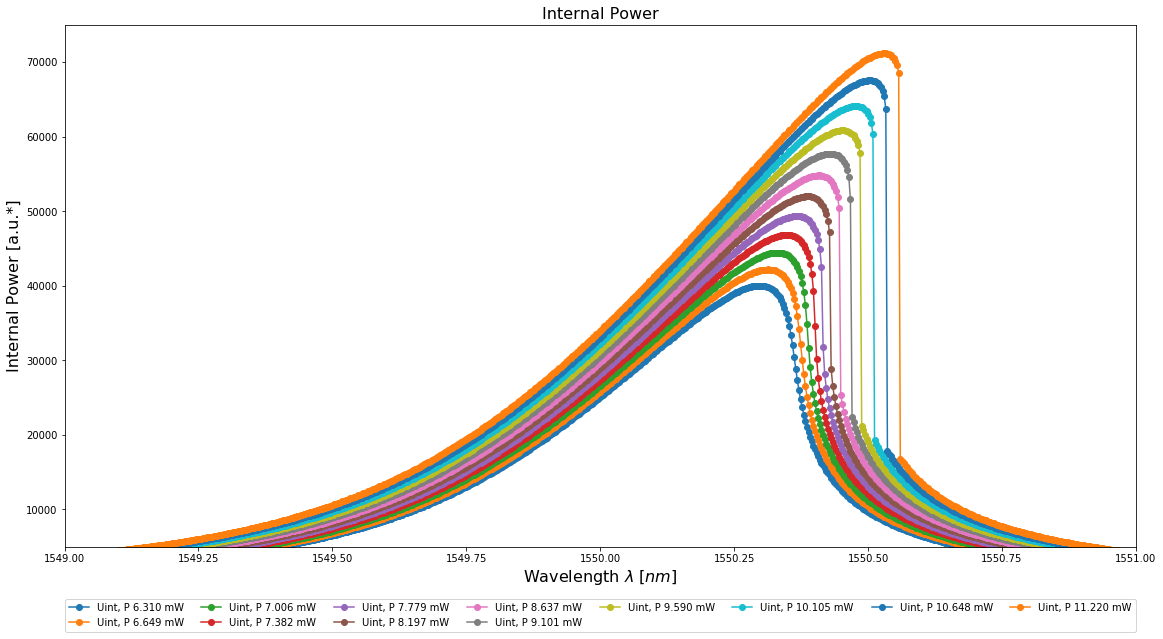

In [5]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

ax1.set_ylim([5e3, 7.5e4])
ax1.set_xlim([1549, 1551])

for E_i in range(E_size):
    #if E_i <= 3:
        ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0], label='Uint, P %.3f mW'%E_range[E_i]**2, ls='-', marker='o')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,1], label='Uint', ls='--')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,2], label='Uint', ls='-.')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Us'][:,E_i,0], label='Uint', ls=':')
        
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0]-np.mean(d['Ut'][:,E_i,0]), label='Uint, P %.3f'%E_range[E_i]**2 ) 
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['Us'][:,E_i,0])**2, label='Us, P %.3fmW'%E_range[E_i]**2)

ax1.set_title( r'Internal Power', fontsize=16)
ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
ax1.set_ylabel(r'Internal Power [a.u.*]', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

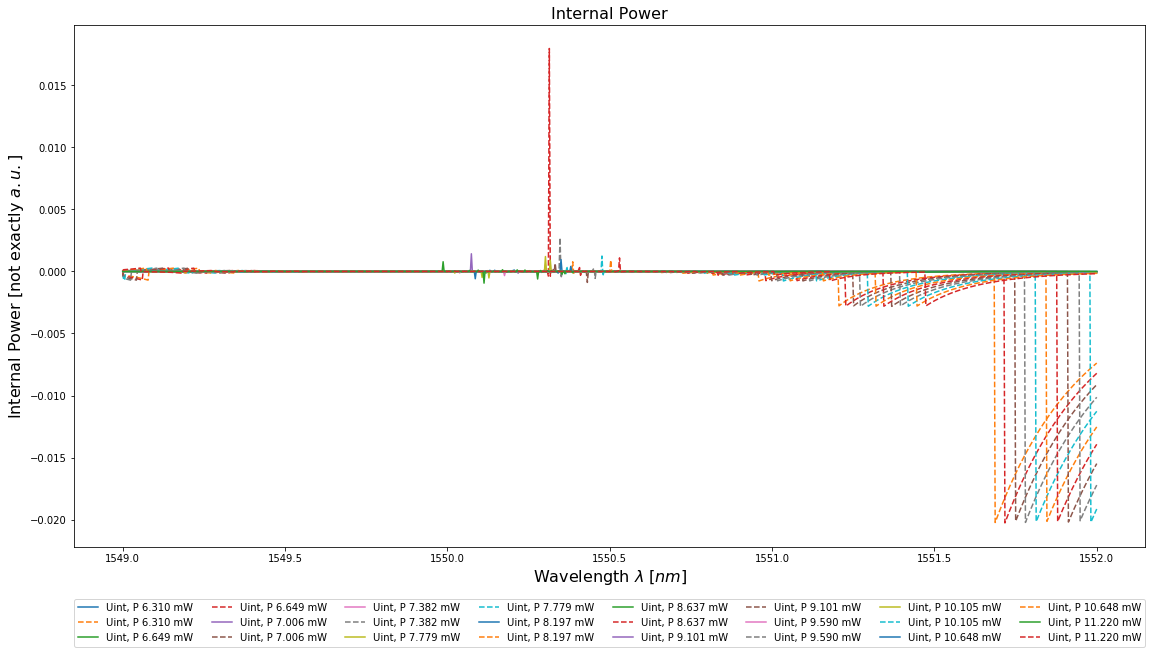

In [6]:
linear = True

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

if not linear:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-20, 1e-2])

for E_i in range(E_size):
    #if E_i <= 3:
        ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0]-d['Ut'][:,E_i,2], label='Uint, P %.3f mW'%E_range[E_i]**2)
        ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,1]-d['Ut'][:,E_i,3], label='Uint, P %.3f mW'%E_range[E_i]**2, ls='--')

ax1.set_title( r'Internal Power', fontsize=16)
ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
ax1.set_ylabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -0.05, 1., -0.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

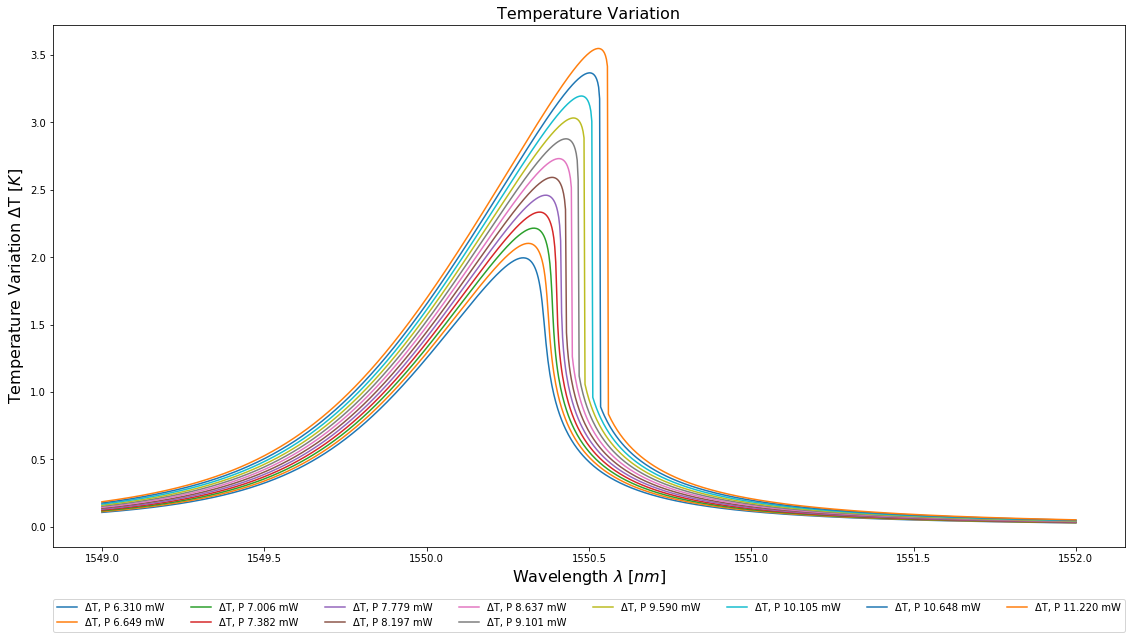

In [7]:
linear = True

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

if not linear:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-20, 1e-2])  

if 0:
    for E_i in range(E_size):
        ax1.plot(1e9*f2w(ω_range*ω0,), d['ΔN'][:,E_i,0], label='ΔN, P %.3f mW'%E_range[E_i]**2)
    ax1.set_title( r'Population Variation', fontsize=16)
    ax1.set_ylabel(r'Population Variation ΔN $[a.u.]$', fontsize=16)

if 1:
    for E_i in range(E_size):
        ax1.plot(1e9*f2w(ω_range*ω0,), d['ΔT'][:,E_i,0], label='ΔT, P %.3f mW'%E_range[E_i]**2)
    ax1.set_title( r'Temperature Variation', fontsize=16)
    ax1.set_ylabel(r'Temperature Variation ΔT $[K]$', fontsize=16)

if 0:
    ax2 = ax1.twinx()
    for E_i in range(E_size):
        ax2.plot(1e9*f2w(ω_range*ω0,), np.real(d['Δω'][:,E_i,0])/ω0, label='RE[Δω], P %.3f mW'%E_range[E_i]**2)
        ax2.plot(1e9*f2w(ω_range*ω0,), np.imag(d['Δω'][:,E_i,0])/ω0, label='IM[Δω], P %.3f mW'%E_range[E_i]**2, ls='--')
    #ax2.set_title( r'Resonance Wavelength Variation', fontsize=16)
    ax2.set_title( r'Physical Quantities Variation', fontsize=16)
    ax2.set_ylabel(r'Resonance Wavelength Variation Δω $[nm]$', fontsize=16)
    
#ax2.set_ylabel('sin', color='r')
#ax2.tick_params('y', colors='r')

ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

In [8]:
vectω = []
vectP = []

for E_i in range(E_size):
    indx = np.where( np.abs(d['Ut'][:,E_i,0])**2==max(np.abs(d['Ut'][:,E_i,0])**2) )
    tmp = f2w(ω_range[indx]*ω0)
    vectω.append(tmp[0])
    tmp = np.abs(d['Ut'][indx,E_i,0])**2
    vectP.append(tmp[0][0])
del indx, tmp
vectω = np.array(vectω)
vectP = np.array(vectP)
#print(vectω)
#print(vectP)

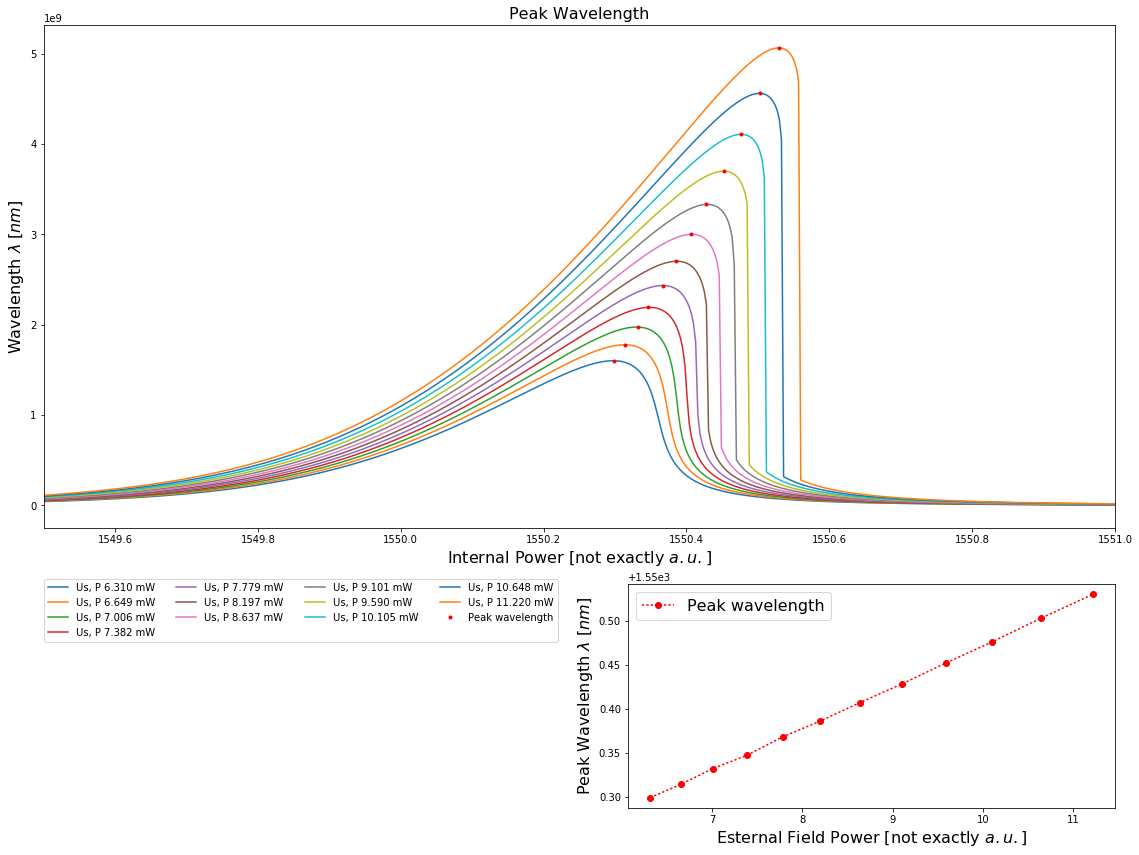

In [16]:
fig = plt.figure(figsize=(3*6.4, 3*4.8)) # default = 6.4, 4.8
gs = gridspec.GridSpec(3, 2)
gs.update(hspace=0.25)

# first graph
ax1 = plt.subplot(gs[0:2, :])

for E_i in range(E_size):
    ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['Ut'][:,E_i,0])**2, label='Us, P %.3f mW'%E_range[E_i]**2)

ax1.set_xlim([1549.5, 1551])

ax1.plot(np.array(vectω)*1.0e9, vectP, '.', label='Peak wavelength', color='red')

ax1.set_title( r'Peak Wavelength', fontsize=16)
ax1.set_xlabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)
ax1.set_ylabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, .48, -.05), loc=2, ncol=4, mode="expand", borderaxespad=0.)

# second graph
ax2 = plt.subplot(gs[2, 1])

ax2.plot(E_range**2, np.array(vectω)*1.0e9, marker='o', ls=':', label='Peak wavelength', color='red')

ax2.set_ylabel(r'Peak Wavelength $\lambda$ $[nm]$', fontsize=16)
ax2.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

legend = ax2.legend(loc='upper left', fontsize=16)

plt.show()
plt.close()

In [ ]:
p2 = np.poly1d(np.polyfit(E_range**2, vectω, 2))
p3 = np.poly1d(np.polyfit(E_range**2, vectω, 3))
p4 = np.poly1d(np.polyfit(E_range**2, vectω, 4))

In [ ]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

ax1.plot(E_range**2, np.array(vectω)*1.0e9, marker='o', ls=':', label='Peak wavelength')
xp = np.linspace(.1, 10**(1.05), 200)
ax1.plot(xp, p2(xp)*1e9, '-', label='polyfit, deg 2')
ax1.plot(xp, p3(xp)*1e9, '--', label='polyfit, deg 3')
ax1.plot(xp, p4(xp)*1e9, ':', label='polyfit, deg 4')

ax1.set_title( r'Fit for Peak Wavelength Power Dependence', fontsize=16)
ax1.set_ylabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
#ax1.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

plt.xticks([])

legend = ax1.legend(loc='lower right', fontsize=16)#, bbox_to_anchor=(1, 0.5))

ax2 = fig.add_subplot(211)

ax2.set_xlim([0, 1])
ax2.set_ylim([1549.999, 1550.021])
plt.yticks(np.linspace(1550,1550.02,5))

ax2.plot(E_range**2, np.array(vectω)*1.0e9, marker='o', ls=':', label='Peak wavelength')
xp = np.linspace(.05, 1, 200)
ax2.plot(xp, p2(xp)*1e9, '-', label='polyfit, deg 2')
ax2.plot(xp, p3(xp)*1e9, '--', label='polyfit, deg 3')
ax2.plot(xp, p4(xp)*1e9, ':', label='polyfit, deg 4')

box = ax2.get_position()
ax2.set_position([box.x0*1.26, box.y0 *0.9, box.width * 0.5, box.height])

ax3 = fig.add_subplot(212)

box = ax3.get_position()
ax3.set_position([box.x0, -1.25 * box.y0, box.width, box.height*0.8])

ax3.plot(E_range**2, E_range*0, '-')
ax3.plot(E_range**2, (np.array(vectω)-p2(E_range**2)) * 1e12, '.-', label='Δλ polyfit, deg 2')
ax3.plot(E_range**2, (np.array(vectω)-p3(E_range**2)) * 1e12, '.--', label='Δλ polyfit, deg 3')
ax3.plot(E_range**2, (np.array(vectω)-p4(E_range**2)) * 1e12, '.:', label='Δλ polyfit, deg 4')

#ax1.set_title( r'Residuals', fontsize=16)
ax3.set_ylabel(r'Δλ $[pm]$', fontsize=16)
ax3.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

plt.show()
plt.close()